# Ajinomoto Study - Pathway 1

In this notebook we demonstrate the use of the Automatic Recommendation Tool (ART) to recommend strain designs for improving dodecanol production using available data for Pathway 1 in Ajinomoto study. We first use cycle 1 data to provide recommendations and include cycle 2 data as test data points. Then, data from the two DBTL cycles jointly is used to provide recommendations for cycle 3.

First we import the package:

In [1]:
import sys
sys.path.append('../../')

import warning_utils
warning_utils.filter_end_user_warnings()

from IPython.display import HTML

from art.core import RecommendationEngine
from art import plot
from art.utility import load_study
from notebooks.paper import ajinomoto

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### First import the whole study and preprocess the data ###


In [2]:
# Strongly recommended workflow is to *greatly* reduce preprocessing work by loading
# standardized data from the  Experiment Data Depot (EDD, https://pubs.acs.org/doi/10.1021/acssynbio.7b00204).
# To skip the EDD registration step for new ART users & support automated notebook testing,
# load a data file downloaded from EDD instead.
load_from_edd = False

if load_from_edd:
    # Load data from EDD:
    #   * Bespoke data formats from well-meaning collaborators explode in complexity very quickly.
    #   * "Slug" is the final URL portion.  For this study, full URL is https://public-edd.jbei.org/s/ajinomoto/
    edd_study_slug = 'ajinomoto'
    edd_server = 'public-edd.jbei.org'
    df_edd = load_study(edd_study_slug=edd_study_slug,edd_server=edd_server, default_to_system_user=False)
else:
    df_edd = load_study(data_file= '../../data/Ajinomoto.csv')

df_edd.head()

,Unnamed: 0,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,0,4384,Ajinomoto,4386,5e9d3479-8113-48cb-8b92-62105a466970,C1-S1-B1.1-R1,NaN,GC-MS,4624,C1-S1-B1.1-R1,cid:8193,dodecan-1-ol,1,g/L,0.72127,27.0
1,1,4384,Ajinomoto,4386,5e9d3479-8113-48cb-8b92-62105a466970,C1-S1-B1.1-R1,NaN,GC-MS,4624,C1-S1-B1.1-R1,cid:2682,hexadecan-1-ol,1,g/L,0.03371,27.0
2,2,4384,Ajinomoto,4386,5e9d3479-8113-48cb-8b92-62105a466970,C1-S1-B1.1-R1,NaN,GC-MS,4624,C1-S1-B1.1-R1,cid:8221,octadecan-1-ol,1,g/L,0.07051,27.0
3,3,4384,Ajinomoto,4386,5e9d3479-8113-48cb-8b92-62105a466970,C1-S1-B1.1-R1,NaN,GC-MS,4624,C1-S1-B1.1-R1,cid:8209,tetradecan-1-ol,1,g/L,0.05971,27.0
4,4,4384,Ajinomoto,4387,1c596cc4-951f-4f1e-b1fb-30b4fcceb306,C1-S1-B1.1-R2,NaN,GC-MS,4625,C1-S1-B1.1-R2,cid:8193,dodecan-1-ol,1,g/L,0.65691,27.0


Preprocessing includes: removing non relevant strains (C0 '9017', 'IPTG' and 'del') from the data set;
adding Cycle number, Strain number, Batch number, Replicate number and Pathway number columns in the dataframe;
combining all replicates and calculating mean and standard deviation;
optimal plotting of gene expression levels ordered for increasing production.


In [3]:
ajinomoto_df, ajinomoto_mean_df = ajinomoto.preprocess(df_edd, plot_flag=False, data_col="Value")


/code/notebooks/paper/../../notebooks/paper/ajinomoto.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ajinomoto_df["Pathway"].loc[
/code/notebooks/paper/../../notebooks/paper/ajinomoto.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ajinomoto_df["Pathway"].loc[
/code/notebooks/paper/../../notebooks/paper/ajinomoto.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ajinomoto_df["Pathway"].loc[
/code/notebooks/paper/../../not

In [4]:
ajinomoto_df.head()

,Line Name,Measurement Type,Value,Cycle,Design,Batch,Replicate,Pathway
0,C1_S1_B1.1-R1,dodecan-1-ol,0.72127,1,1,1,1,1
1,C1_S1_B1.1-R1,hexadecan-1-ol,0.03371,1,1,1,1,1
2,C1_S1_B1.1-R1,octadecan-1-ol,0.07051,1,1,1,1,1
3,C1_S1_B1.1-R1,tetradecan-1-ol,0.05971,1,1,1,1,1
4,C1_S1_B1.1-R2,dodecan-1-ol,0.65691,1,1,1,2,1


In [5]:
ajinomoto_mean_df.head()

Measurement Type,A1U2T0,A1U3L3,AHR_ECOLI,"Dodecanoyl-[acyl-carrier-protein] hydrolase, chloroplastic",Fatty acyl-CoA reductase,LCFA_ECOLI,dodecan-1-ol
Design,,,,,,,
1,1400.4,136244.400000,252.6,141483.000000,661.200000,98879.400000,0.655988
2,466.4,151604.200000,469.8,145170.600000,79.200000,113269.000000,0.606746
3,964.0,131395.333333,1660.0,127283.666667,80.666667,353878.333333,0.168947
4,931.0,572420.000000,358.5,115678.500000,676.000000,81778.000000,0.468715
5,0.0,447718.000000,891.0,108267.000000,0.000000,85735.333333,0.539463


### Proceed with the task of maximazing dodecanol production ###

Define ART input parameters:

In [6]:
art_params = {
    'input_vars': [
        'Dodecanoyl-[acyl-carrier-protein] hydrolase, chloroplastic',
        'LCFA_ECOLI',
        'A1U3L3'
    ],
    'response_vars': ['dodecan-1-ol'],
    'objective':'maximize',
    'threshold': 0.2,
    'verbose': 1,
    'seed': 10,
    'output_dir': '../../results/Dodecanol_P1',
    'cross_val': True,
    'recommend': False,
    'num_recommendations': 10,
    'build_model': False,
    'max_mcmc_cores': 2,
}

In [7]:
# Set Pathway Variant
pathway_variant = 1

df = ajinomoto_df[['Line Name','Measurement Type','Value']].loc[ajinomoto_df['Pathway']==pathway_variant]

# Create Report Heading
title = '<h2>Pathway Maqu_2507 Titer Maximization.<br/>Recommendations for protein expressions provided.</h2>'
display(HTML(title))

Define training (Cycle 1) and test (Cycle 2) samples.

In [8]:
df_1 = df[df['Line Name'].str.contains('C1')]
df_2 = df[df['Line Name'].str.contains('C2')]

In [9]:
art_C1 = RecommendationEngine(df=df_1, **art_params)
art_test = RecommendationEngine(df=df_2, **art_params)

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.
Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 19 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
ART identified 13 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.


How many instances/replicates?

In [10]:
print(f'Cycle 1: {len(art_C1.df)}\nCycle 2: {len(art_test.df)}')


Cycle 1: 50
Cycle 2: 39


How manu unique designs/strains?

In [11]:
lines1 = [line.split('_')[1] for line in art_C1.df.index]
lines2 = [line.split('_')[1] for line in art_test.df.index]
print(f'Cycle 1: {len(set(lines1))}\nCycle 2: {len(set(lines2))}')


Cycle 1: 12
Cycle 2: 11


How many replicates resulted in no product detected?

In [12]:
product = art_C1.df['Response Variables','dodecan-1-ol']
zero_product1 = product[product==0]
product = art_test.df['Response Variables','dodecan-1-ol']
zero_product2 = product[product==0]
print(f'Cycle 1: {len(zero_product1)}\nCycle 2: {len(zero_product2)}')


Cycle 1: 0
Cycle 2: 6


How many strains resulted in no product detected?

In [13]:
lines1 = [line.split('_')[1] for line in zero_product1.index]
lines2 = [line.split('_')[1] for line in zero_product2.index]
print(f'Cycle 1: {len(set(lines1))}\nCycle 2: {len(set(lines2))}')


Cycle 1: 0
Cycle 2: 2


## DBTL Cycle 1 ##

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


ART identified 19 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.01, max_depth=5, min_child_weight=17, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.45, verbosity=0)
Done fitting L0 models in 40.77 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 18.77 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(LinearSVR(MaxAbsScaler(input_matrix), C=0.1, dual=True, epsilon=0.01, loss=epsilon_insensitive, tol=0.001), learning_rate=1.0, loss=linear, n_estimators=100)
Done fitting L0 models in 81.82 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 15.37 s
Fitting L0 models…
Building TPOT models…
Best pipeline: GradientBoostingRegressor(ElasticNetCV(Normalizer(FeatureAgglomeration(input_matrix, affinity=l1, linkage=complete), norm=max), l1_ratio=0.2, tol=0.001), alpha=0.85, learning_rate=0.5, loss=quantile, max_depth=3, max_features=0.9000000000000001, min_samples_leaf=9, min_samples_split=20, n_estimators=100, subsample=0.05)
Done fitting L0 models in 62.87 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 20.10 s
Fitting L0 models…
Building TPOT models…
Best pipeline: KNeighborsRegressor(RidgeCV(Normalizer(GradientBoostingRegressor(Normalizer(input_matrix, norm=l1), alpha=0.85, learning_rate=0.5, loss=huber, max_depth=5, max_features=0.35000000000000003, min_samples_leaf=11, min_samples_split=12, n_estimators=100, subsample=0.6500000000000001), norm=max)), n_neighbors=31, p=2, weights=distance)
Done fitting L0 models in 68.02 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 14.00 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(RandomForestRegressor(RidgeCV(Normalizer(input_matrix, norm=l1)), bootstrap=False, max_features=0.15000000000000002, min_samples_leaf=9, min_samples_split=3, n_estimators=100), learning_rate=1.0, loss=linear, n_estimators=100)
Done fitting L0 models in 49.23 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 22.87 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(SGDRegressor(input_matrix, alpha=0.001, eta0=1.0, fit_intercept=False, l1_ratio=0.5, learning_rate=invscaling, loss=huber, penalty=elasticnet, power_t=0.1), learning_rate=0.1, loss=square, n_estimators=100)
Done fitting L0 models in 84.93 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 14.16 s
Fitting L0 models…
Building TPOT models…
Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=15, p=2, weights=distance)
Done fitting L0 models in 4.16 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 14.47 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=0.01, loss=linear, n_estimators=100)
Done fitting L0 models in 4.54 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 13.93 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(RobustScaler(RobustScaler(LassoLarsCV(input_matrix, normalize=False))), learning_rate=0.01, loss=linear, n_estimators=100)
Done fitting L0 models in 70.88 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 19.26 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RandomForestRegressor(Nystroem(input_matrix, gamma=0.6000000000000001, kernel=additive_chi2, n_components=5), bootstrap=True, max_features=0.15000000000000002, min_samples_leaf=1, min_samples_split=6, n_estimators=100)
Done fitting L0 models in 3.54 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 14.21 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.128870,55.804573,0.108392,0.028356,0.231248
Random Forest Regressor,0.176136,91.173658,0.203425,0.072406,-0.962942
Support Vector Regressor,0.156382,71.955774,0.145230,0.045547,-0.234790
Kernel Ridge Regressor,0.193520,74.117400,0.155914,0.061759,-0.674313
K-NN Regressor,0.153916,83.688788,0.178973,0.055721,-0.510623
Gaussian Process Regressor,0.140798,75.270447,0.157099,0.044504,-0.206522
Gradient Boosting Regressor,0.185073,92.919215,0.210472,0.078551,-1.129531
TPOT Regressor,0.157392,76.714663,0.156942,0.049403,-0.339333
Ensemble Model,0.150126,73.317909,0.146580,0.044023,-0.193487


Done with 10-fold cross-validation in 650.79 s


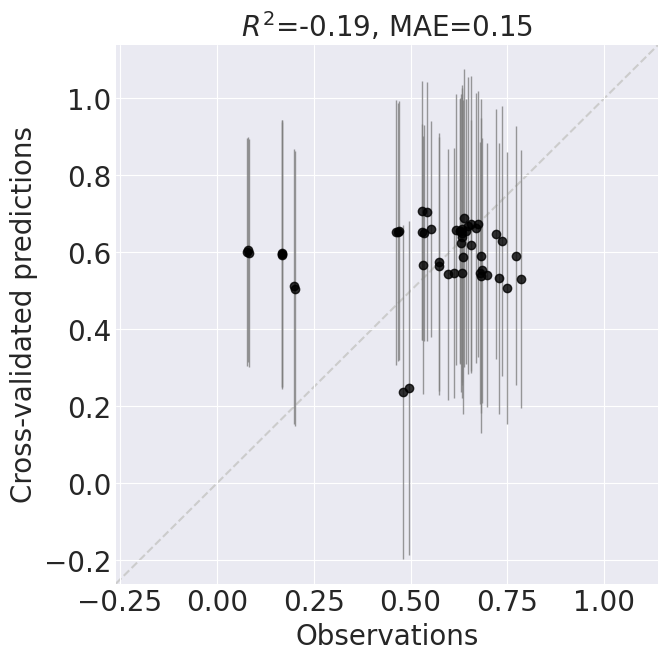

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(FastICA(ZeroCount(input_matrix), tol=0.65), learning_rate=0.5, loss=square, n_estimators=100)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Done fitting L0 models in 96.59 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 14.24 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.070225,14.643109,0.060248,0.008561,0.767900
Random Forest Regressor,0.017608,6.035501,0.023163,0.000847,0.977050
Support Vector Regressor,0.066723,20.413606,0.032348,0.005498,0.850939
Kernel Ridge Regressor,0.101806,35.951293,0.068570,0.015066,0.591545
K-NN Regressor,0.079541,39.040183,0.088502,0.014159,0.616137
Gaussian Process Regressor,0.011543,2.571300,0.011975,0.000277,0.992500
Gradient Boosting Regressor,0.006124,1.346240,0.006252,0.000077,0.997923
TPOT Regressor,0.019166,3.528067,0.015291,0.000601,0.983704
Ensemble Model,0.061869,14.628543,0.048676,0.006197,0.831994


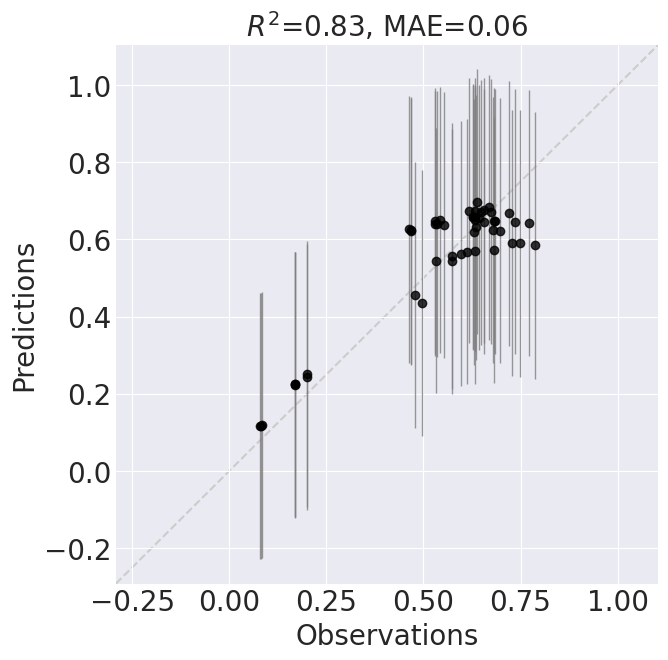

Done building models in 112.50 s
CPU times: user 10min 11s, sys: 5.75 s, total: 10min 16s
Wall time: 12min 43s


In [14]:
%%time
# Run ART
art_params['build_model'] = True
art_C1 = RecommendationEngine(df=df_1, result_suffix="_C1", **art_params)

In [15]:
art_C1.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.128870,55.804573,0.108392,0.028356,0.231248
Random Forest Regressor,0.176136,91.173658,0.203425,0.072406,-0.962942
Support Vector Regressor,0.156382,71.955774,0.145230,0.045547,-0.234790
Kernel Ridge Regressor,0.193520,74.117400,0.155914,0.061759,-0.674313
K-NN Regressor,0.153916,83.688788,0.178973,0.055721,-0.510623
Gaussian Process Regressor,0.140798,75.270447,0.157099,0.044504,-0.206522
Gradient Boosting Regressor,0.185073,92.919215,0.210472,0.078551,-1.129531
TPOT Regressor,0.157392,76.714663,0.156942,0.049403,-0.339333
Ensemble Model,0.150126,73.317909,0.146580,0.044023,-0.193487


In [16]:
art_C1.evaluate_models(art_C1.X, art_C1.y)

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.070225,14.643109,0.060248,0.008561,0.767900
Random Forest Regressor,0.017608,6.035501,0.023163,0.000847,0.977050
Support Vector Regressor,0.066723,20.413606,0.032348,0.005498,0.850939
Kernel Ridge Regressor,0.101806,35.951293,0.068570,0.015066,0.591545
K-NN Regressor,0.079541,39.040183,0.088502,0.014159,0.616137
Gaussian Process Regressor,0.011543,2.571300,0.011975,0.000277,0.992500
Gradient Boosting Regressor,0.006124,1.346240,0.006252,0.000077,0.997923
TPOT Regressor,0.019166,3.528067,0.015291,0.000601,0.983704
Ensemble Model,0.061869,14.628543,0.048676,0.006197,0.831994


In [17]:
X_test = art_test.X
y_test = art_test.y
display(HTML('Evaluation of learned predictive models on test data:'))
art_C1.evaluate_models(X_test, y_test)

/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.258896,inf,0.180313,0.099540,-0.328845
Random Forest Regressor,0.292744,inf,0.136029,0.104203,-0.391096
Support Vector Regressor,0.254338,inf,0.129382,0.081428,-0.087046
Kernel Ridge Regressor,0.220448,inf,0.110235,0.060749,0.189009
K-NN Regressor,0.352435,inf,0.153977,0.147919,-0.974701
Gaussian Process Regressor,0.319435,inf,0.158226,0.127074,-0.696421
Gradient Boosting Regressor,0.261194,inf,0.109439,0.080199,-0.070647
TPOT Regressor,0.380781,inf,0.184008,0.178853,-1.387662
Ensemble Model,0.249574,inf,0.166598,0.090042,-0.202052


Plot observations vs. predictions distributions for the train and test data.

Use the ensemble model to predict Cycle 2 strain performance.

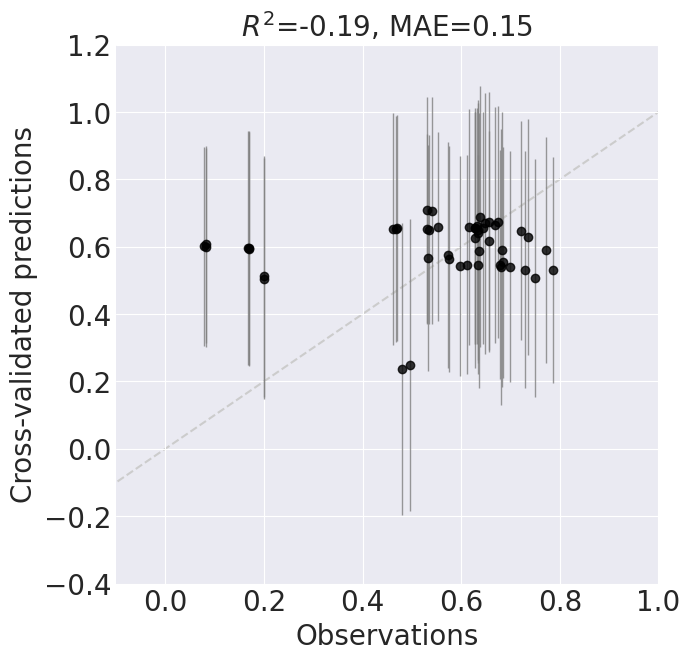

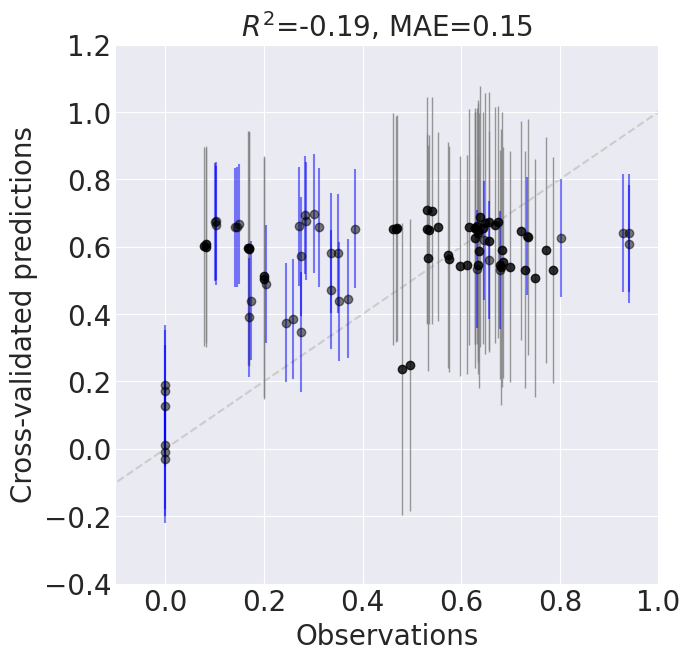

In [18]:
plot.predictions_vs_observations(art_C1, cv=True, error_bars=True,
                                 x_limits=[[-0.1, 1.]], y_limits=[[-0.4, 1.2]])
plot.predictions_vs_observations(art_C1, cv=True, error_bars=True, X_test=X_test, y_test=y_test,
                                 x_limits=[[-0.1, 1.]], y_limits=[[-0.4, 1.2]])


Perform sampling-based optimization using the ensemble model

In [19]:
%%time
draws = art_C1.generate_recommendation_candidates()

Starting parallel tempering using 2 chains…
Done with parallel tempering in 865.30 s
CPU times: user 91.1 ms, sys: 13.2 ms, total: 104 ms
Wall time: 14min 25s


Choosing recommendations (19,800 candidates)…


Done choosing recommendations in 0.03 s


,"Dodecanoyl-[acyl-carrier-protein] hydrolase, chloroplastic",LCFA_ECOLI,A1U3L3,dodecan-1-ol
0,83338.889054,46406.386522,905786.841622,0.723118
1,84548.005564,67294.097455,813569.721058,0.715346
2,87304.558358,86321.643451,822009.728513,0.708280
3,90070.233249,66356.298907,978049.284726,0.707836
4,75374.117881,45212.338834,701627.989306,0.707450
5,75922.517441,77034.791307,515190.567234,0.704054
6,82693.561793,152832.087676,986257.576089,0.703627
7,74929.234220,55779.242233,513569.821279,0.701852
8,80591.372915,79843.361784,629512.699495,0.701235
9,71226.671536,44119.943862,557398.467231,0.695046


Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.77 s


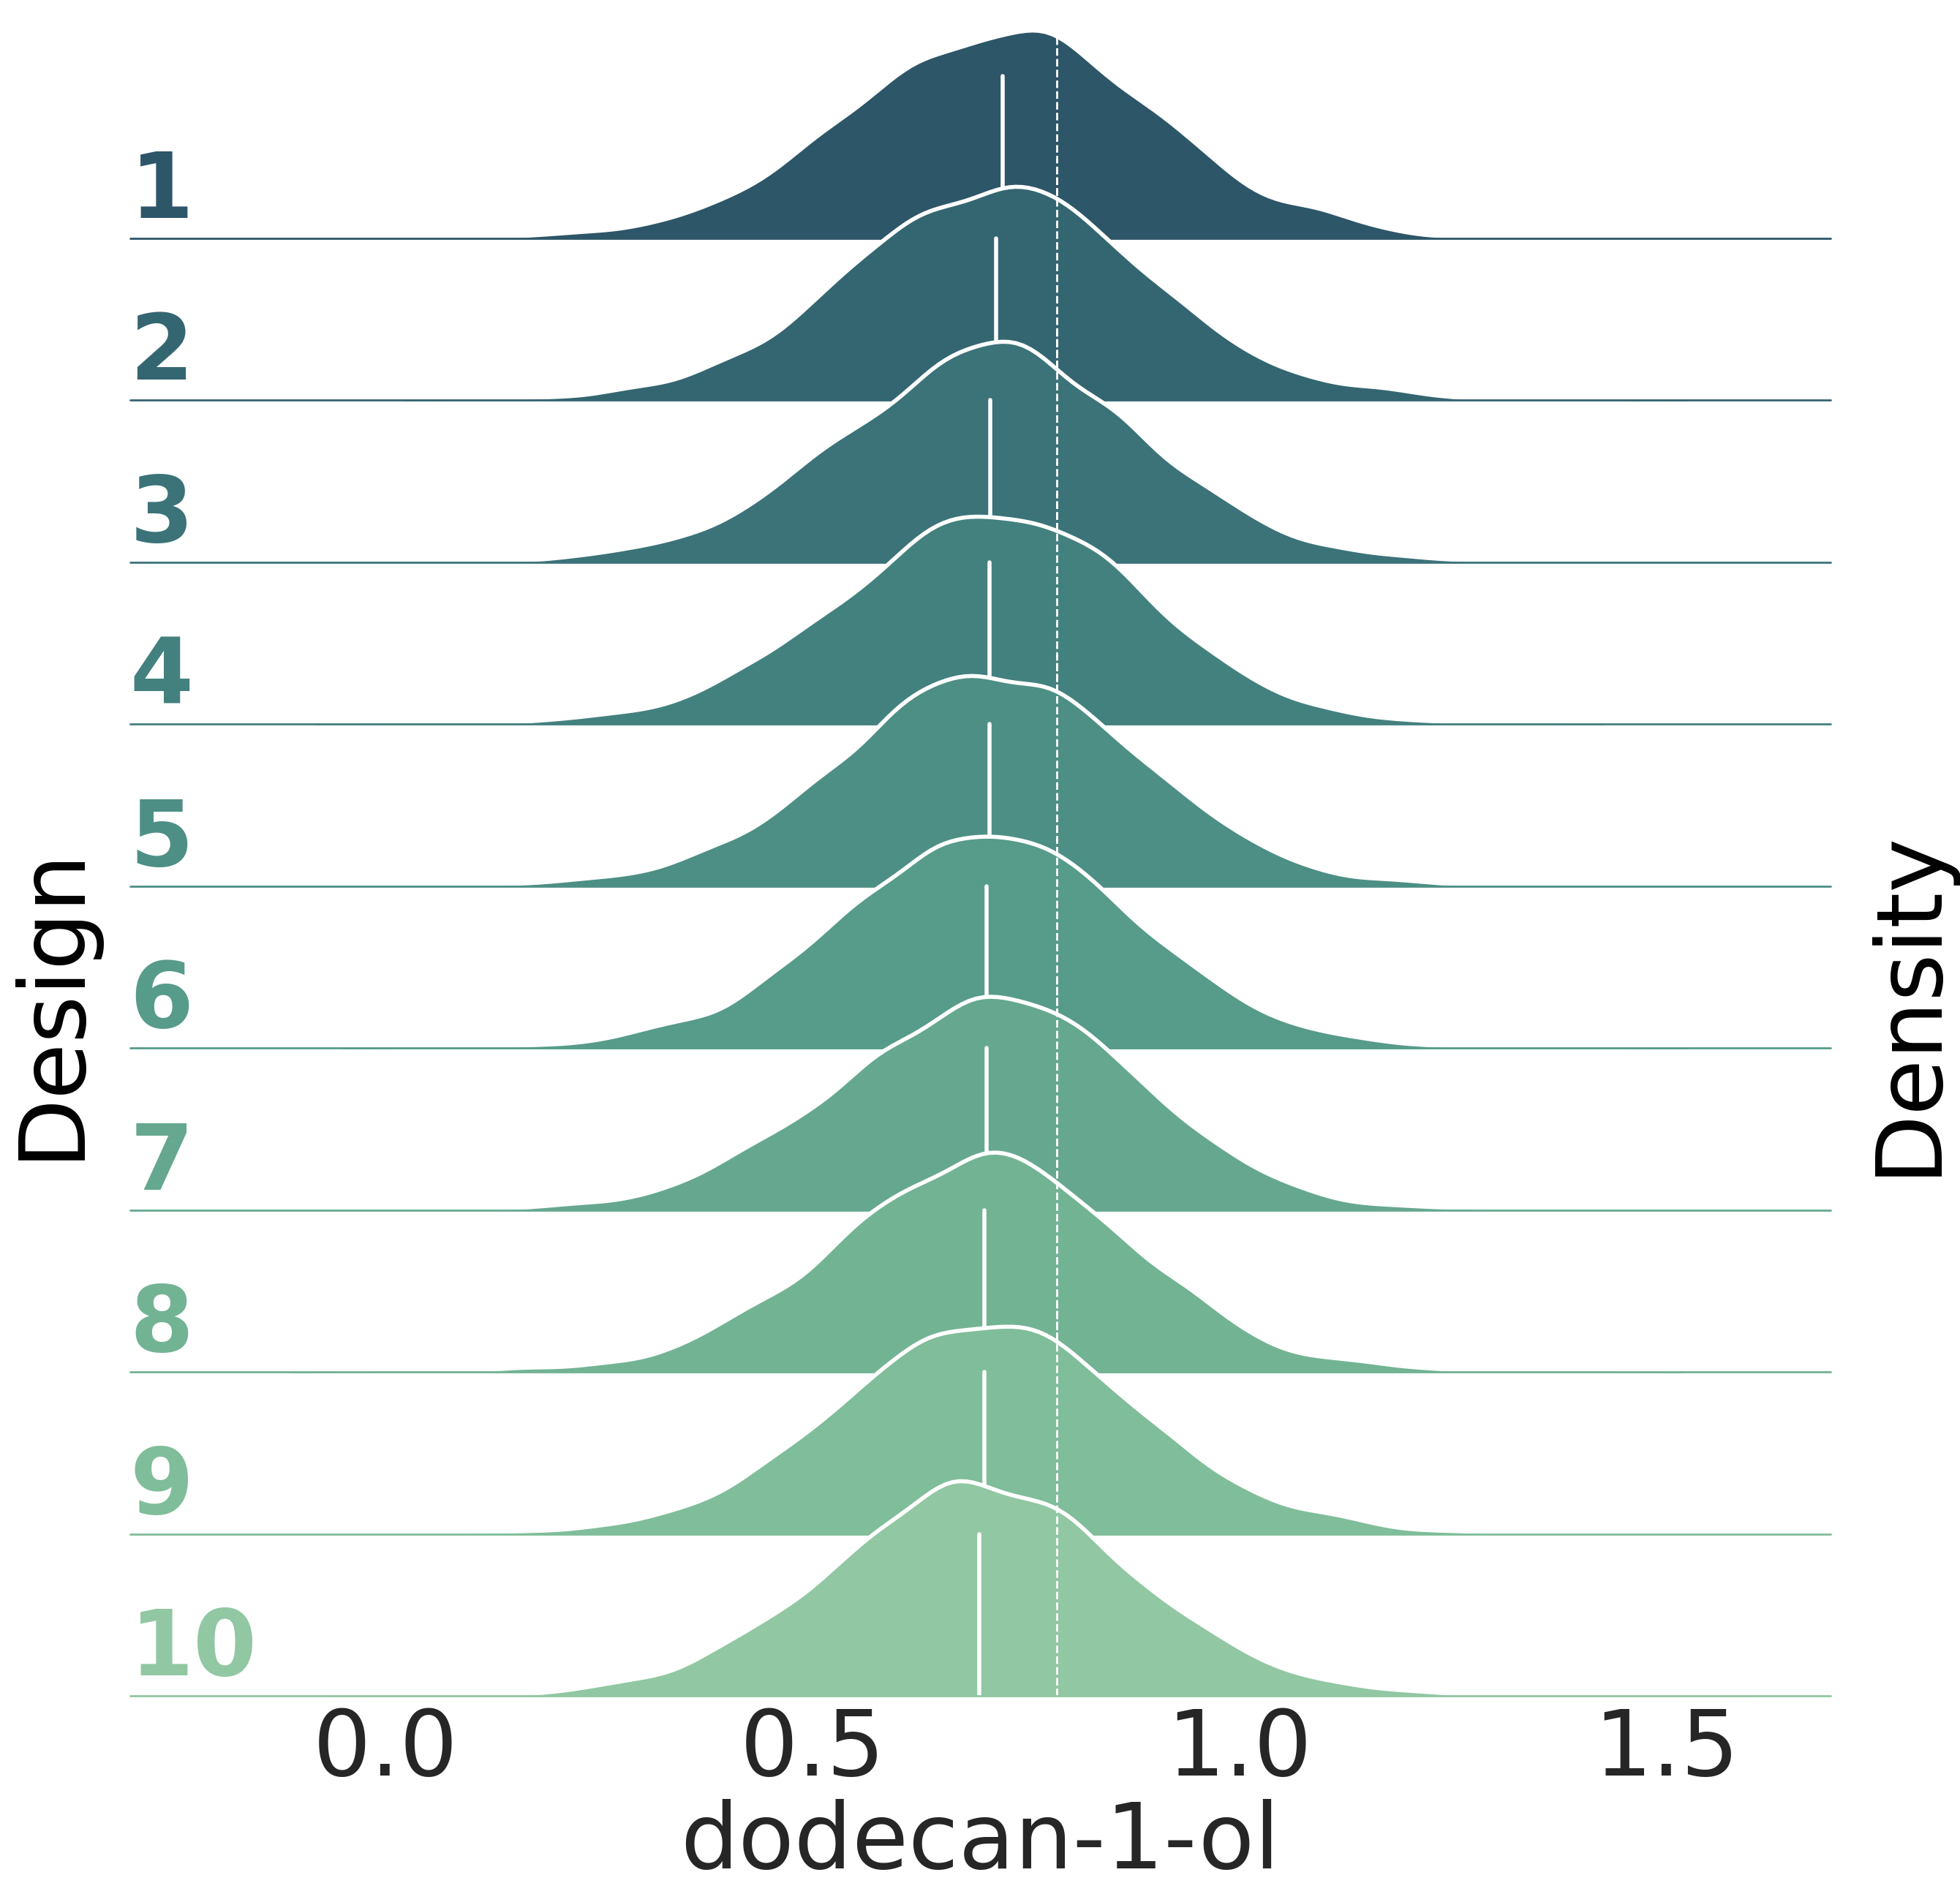

Computing success probabilities…
Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 0.99 s
Done computing success probabilities in 0.99 s


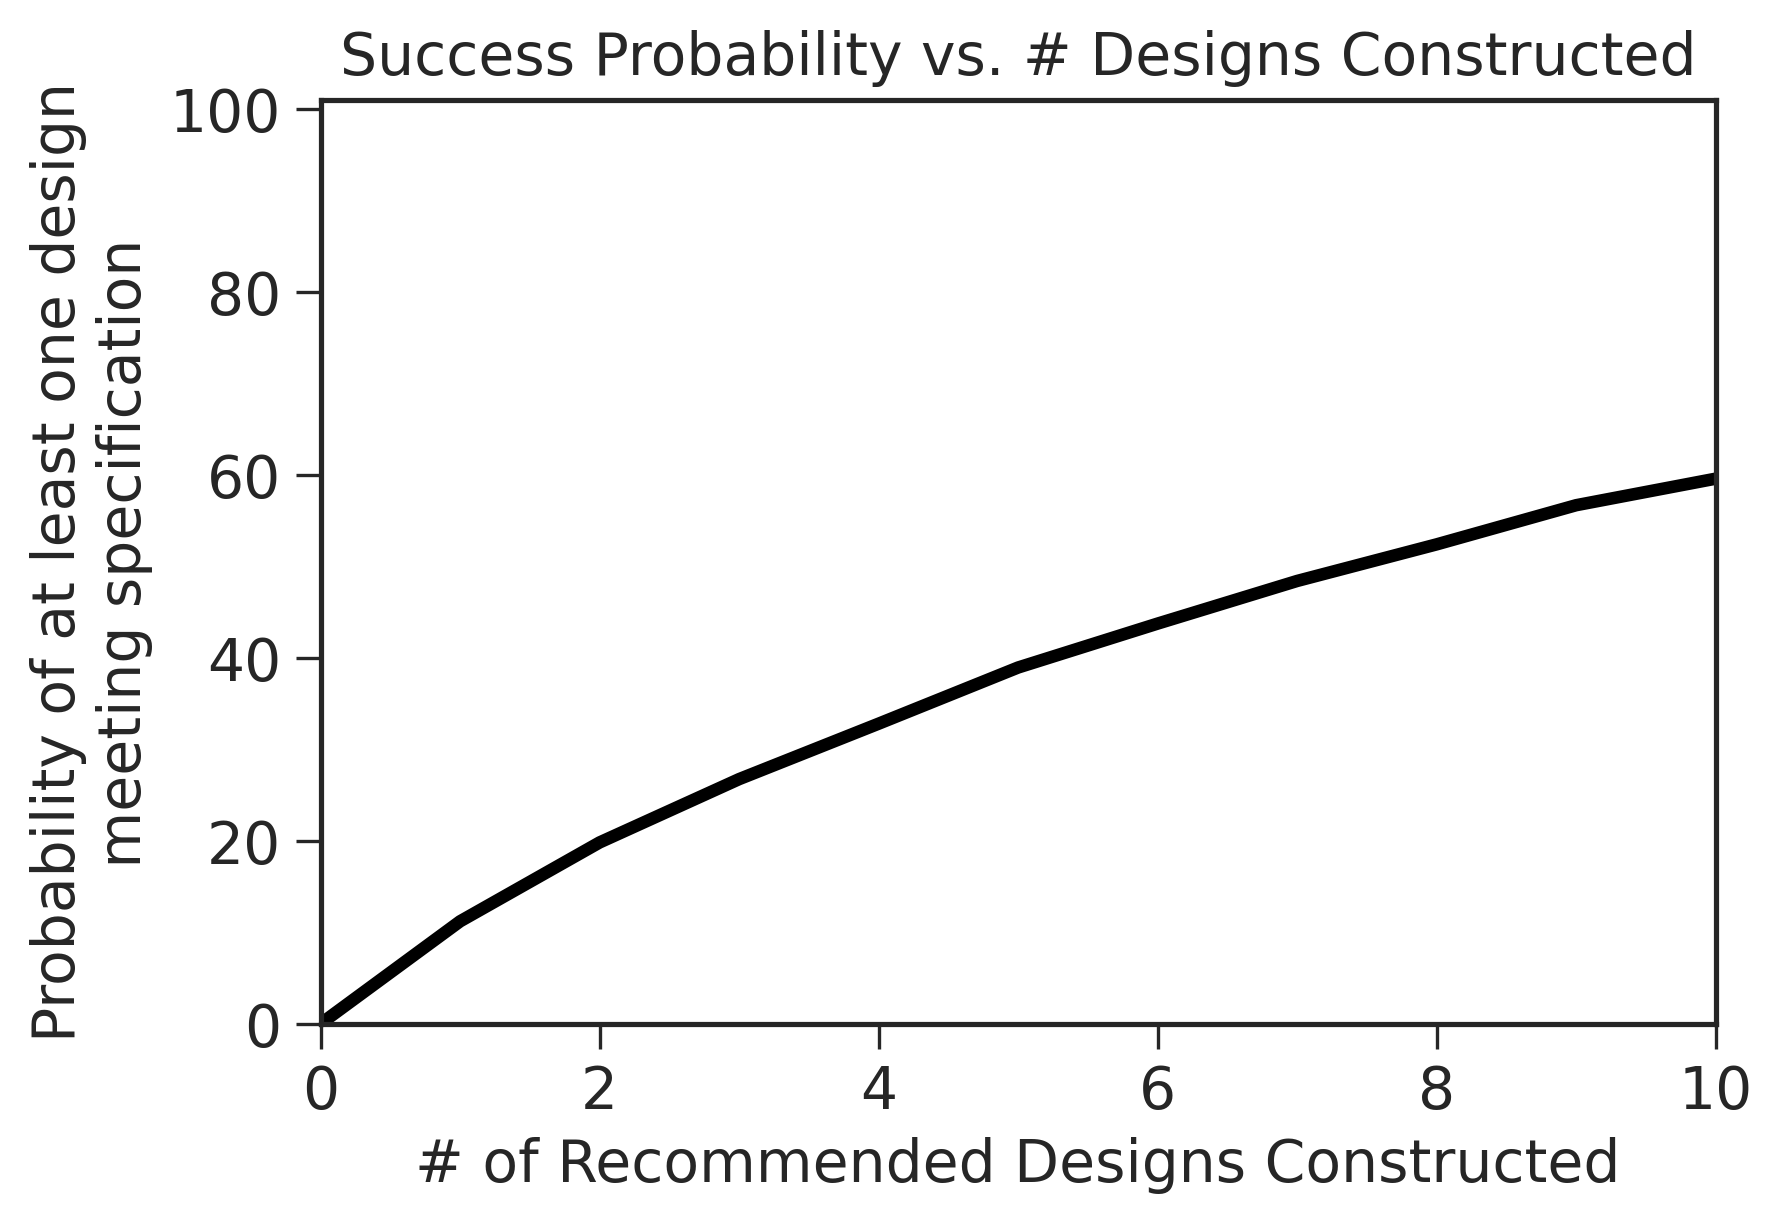

In [20]:
art_C1.select_recommendations(draws)

Visualize the predicted dodecanol mean production levels (solid lines) and the associated uncertainty (distributions).
Dashed lines show production levels for the test data points.

Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.74 s


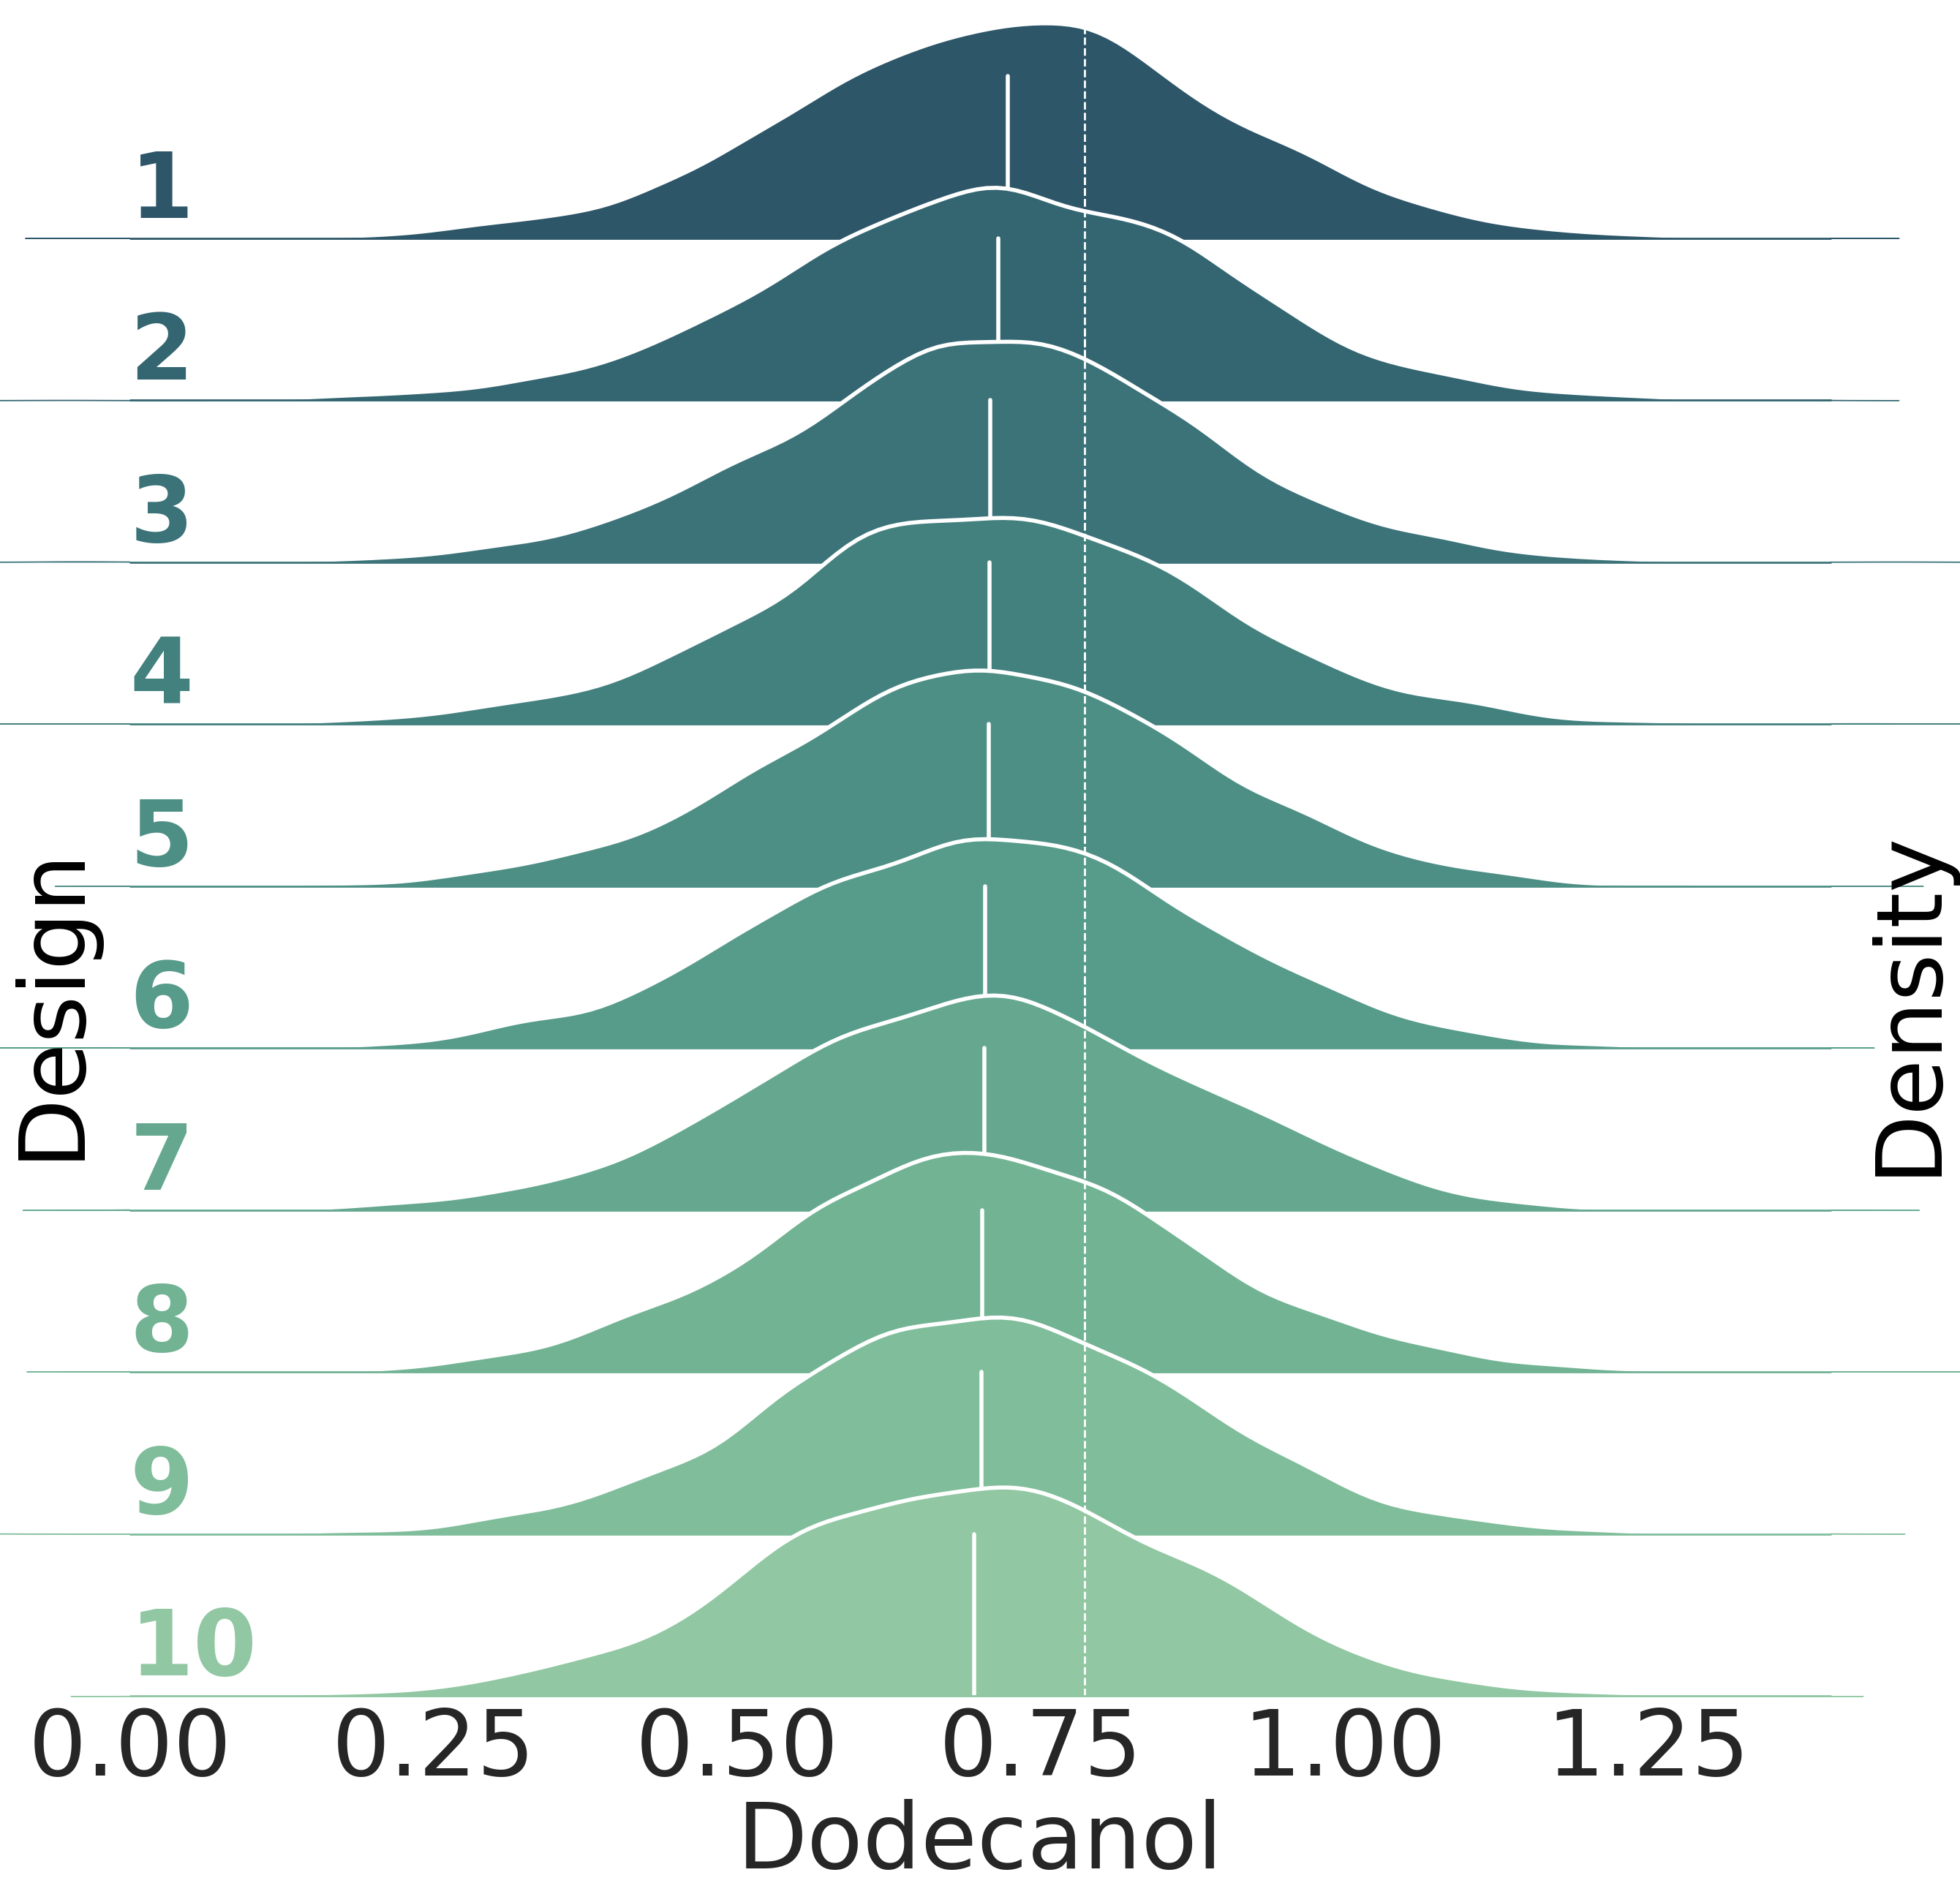

In [21]:
name = ['Dodecanol']
plot.recomm_distribution(art_C1, name,[0,1.4])

Plot probability of success

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.73 s
Done computing success probabilities in 0.73 s


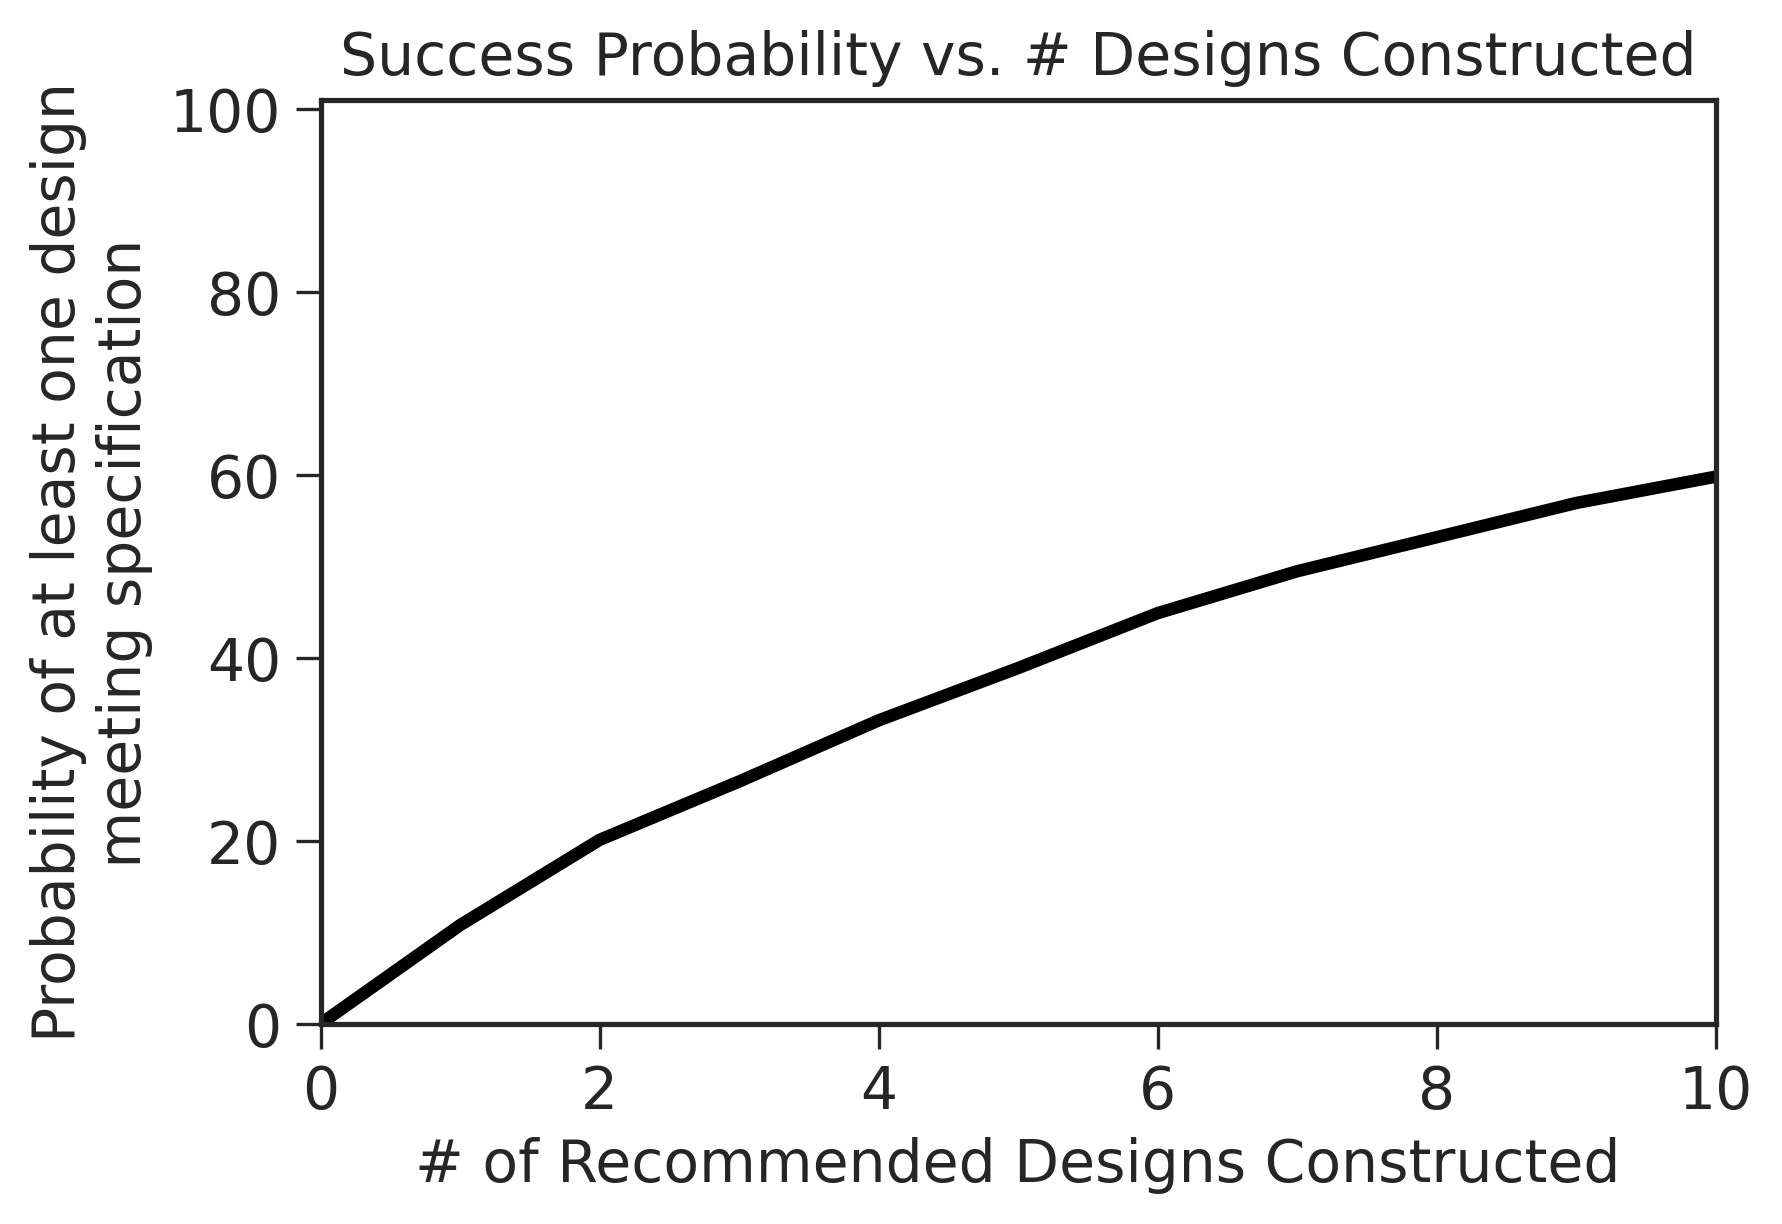

In [22]:
cum_success_prob = art_C1.compute_success_prob(current_best=art_C1.find_current_best())
plot.success_prob(art_C1, cum_success_prob)

Visualize the first two principal components of draws from the samapling phase and show train, i.e. Cycle 1 data (in red).

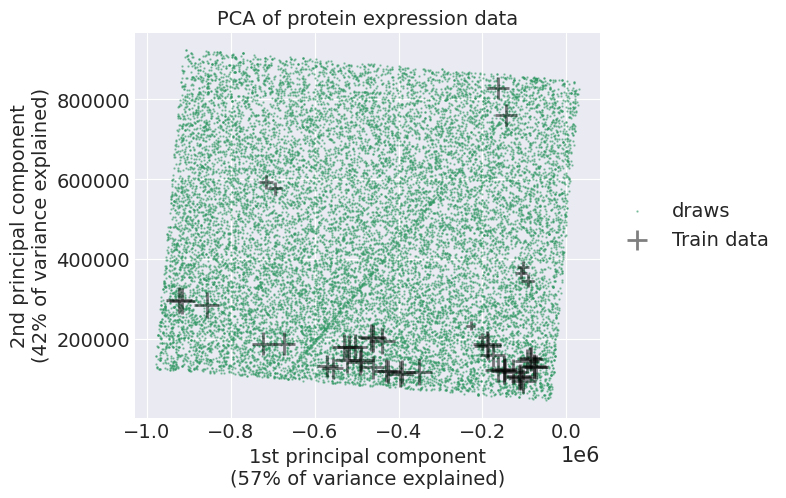

In [23]:
plot.draws_pc(art_C1, draws, plot_scale_factor=500, plot_draws=True, plot_kde=False)

Visualize the first two principal components of the recommendations and train (cycle 1) and test (Cycle 2) data

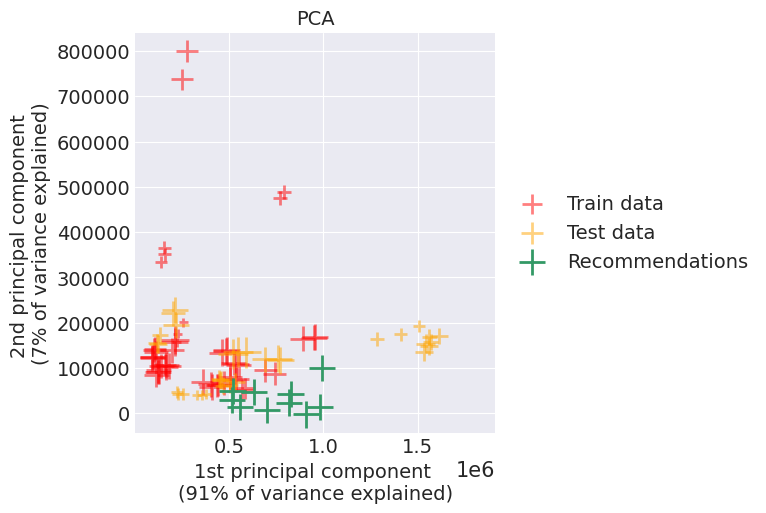

In [24]:
plot.recommendations_pc(art_C1, plot_scale_factor=500, X_test=X_test, label_test='Test data', objective_value_y_test=y_test)

In [25]:
art_C1.save()

#### Recommend strains for the next DBTL cycle ####

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


ART identified 32 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.6000000000000001, min_samples_leaf=16, min_samples_split=19, n_estimators=100), learning_rate=0.1, max_depth=9, min_child_weight=4, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6500000000000001, verbosity=0)
Done fitting L0 models in 44.85 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 18.39 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=9, min_samples_split=14, n_estimators=100), learning_rate=0.5, max_depth=10, min_child_weight=7, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7000000000000001, verbosity=0)
Done fitting L0 models in 50.36 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 21.08 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ExtraTreesRegressor(Normalizer(input_matrix, norm=l1), bootstrap=False, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
Done fitting L0 models in 65.97 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 19.04 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(RidgeCV(input_matrix), learning_rate=0.5, loss=exponential, n_estimators=100)
Done fitting L0 models in 68.77 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 13.99 s
Fitting L0 models…
Building TPOT models…
Best pipeline: DecisionTreeRegressor(AdaBoostRegressor(PolynomialFeatures(PCA(input_matrix, iterated_power=7, svd_solver=randomized), degree=2, include_bias=False, interaction_only=False), learning_rate=0.1, loss=square, n_estimators=100), max_depth=3, min_samples_leaf=2, min_samples_split=7)
Done fitting L0 models in 44.73 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 23.51 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=9, min_child_weight=13, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.1, verbosity=0)
Done fitting L0 models in 58.30 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 15.68 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(Normalizer(SGDRegressor(input_matrix, alpha=0.001, eta0=1.0, fit_intercept=False, l1_ratio=1.0, learning_rate=constant, loss=epsilon_insensitive, penalty=elasticnet, power_t=0.0), norm=l2), learning_rate=1.0, loss=square, n_estimators=100)
Done fitting L0 models in 71.29 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 16.46 s
Fitting L0 models…
Building TPOT models…
Best pipeline: RidgeCV(AdaBoostRegressor(OneHotEncoder(OneHotEncoder(input_matrix, minimum_fraction=0.05, sparse=False, threshold=10), minimum_fraction=0.05, sparse=False, threshold=10), learning_rate=0.1, loss=exponential, n_estimators=100))
Done fitting L0 models in 80.29 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 14.27 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ExtraTreesRegressor(RidgeCV(input_matrix), bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=3, n_estimators=100)
Done fitting L0 models in 58.98 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 13.45 s
Fitting L0 models…
Building TPOT models…
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=8, min_child_weight=1, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0)
Done fitting L0 models in 47.75 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 15.41 s


/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.191863,inf,0.135903,0.055281,0.148719
Random Forest Regressor,0.161889,inf,0.150531,0.048868,0.247480
Support Vector Regressor,0.137612,inf,0.111755,0.031426,0.516067
Kernel Ridge Regressor,0.179241,inf,0.121560,0.046904,0.277716
K-NN Regressor,0.181277,inf,0.164461,0.059909,0.077456
Gaussian Process Regressor,0.177255,inf,0.143469,0.052003,0.199202
Gradient Boosting Regressor,0.166527,inf,0.154362,0.051559,0.206039
TPOT Regressor,0.190845,inf,0.140057,0.056038,0.137066
Ensemble Model,0.146604,inf,0.123313,0.036699,0.434871


Done with 10-fold cross-validation in 776.59 s


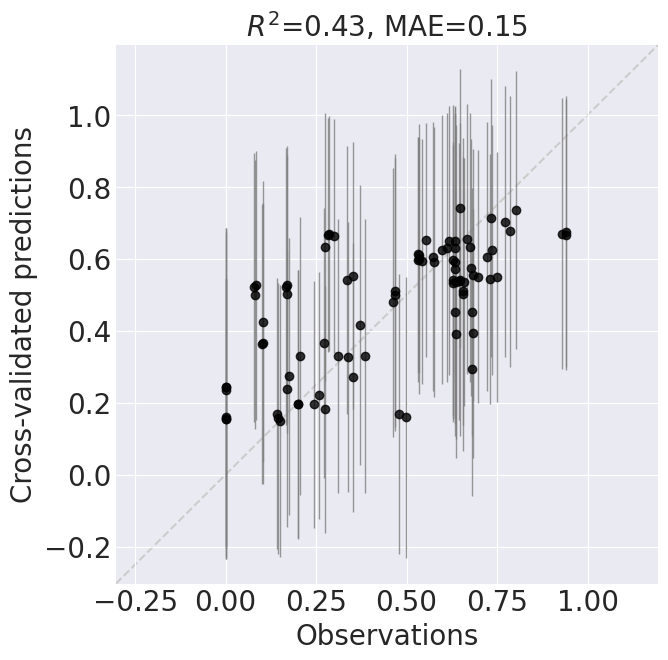

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: DecisionTreeRegressor(CombineDFs(input_matrix, input_matrix), max_depth=10, min_samples_leaf=15, min_samples_split=16)
Done fitting L0 models in 3.25 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 13.90 s


/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])
/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: invalid value encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.142307,inf,0.125938,0.036112,0.443910
Random Forest Regressor,0.025254,inf,0.028784,0.001466,0.977420
Support Vector Regressor,0.088161,inf,0.065157,0.012018,0.814938
Kernel Ridge Regressor,0.131025,inf,0.091726,0.025581,0.606073
K-NN Regressor,0.081136,NaN,0.070562,0.011562,0.821956
Gaussian Process Regressor,0.012979,inf,0.013536,0.000352,0.994584
Gradient Boosting Regressor,0.010968,inf,0.010224,0.000225,0.996538
TPOT Regressor,0.137829,inf,0.120014,0.033400,0.485668
Ensemble Model,0.077097,inf,0.057383,0.009237,0.857761


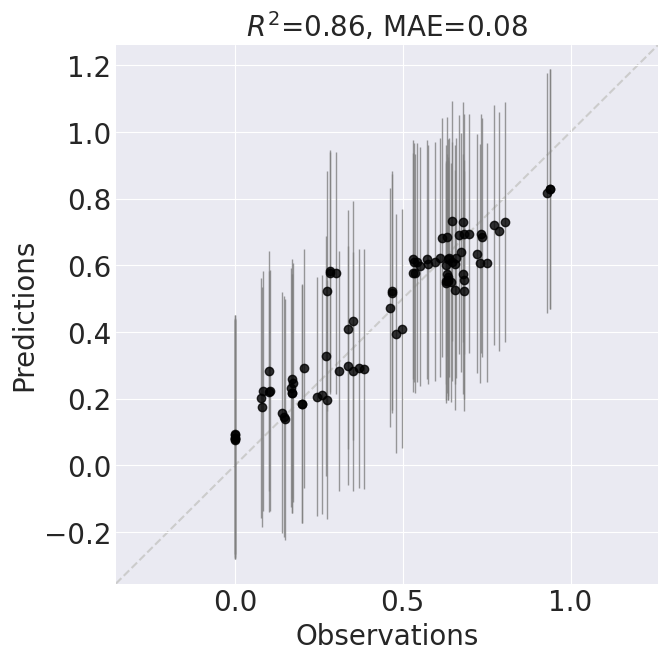

Done building models in 18.58 s


In [26]:
art_C2 = RecommendationEngine(df=df, result_suffix="_C2", **art_params)

In [27]:
art_C2.evaluate_models()

/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: divide by zero encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])
/code/notebooks/paper/../../art/utility.py:271: RuntimeWarning: invalid value encountered in scalar divide
  rel_abs_error = np.abs([(y_a - y_p) / y_a for y_a, y_p in zip(y_actual, y_predict)])


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.142307,inf,0.125938,0.036112,0.443910
Random Forest Regressor,0.025254,inf,0.028784,0.001466,0.977420
Support Vector Regressor,0.088161,inf,0.065157,0.012018,0.814938
Kernel Ridge Regressor,0.131025,inf,0.091726,0.025581,0.606073
K-NN Regressor,0.081136,NaN,0.070562,0.011562,0.821956
Gaussian Process Regressor,0.012979,inf,0.013536,0.000352,0.994584
Gradient Boosting Regressor,0.010968,inf,0.010224,0.000225,0.996538
TPOT Regressor,0.137829,inf,0.120014,0.033400,0.485668
Ensemble Model,0.077097,inf,0.057383,0.009237,0.857761


In [28]:
art_C2.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.191863,inf,0.135903,0.055281,0.148719
Random Forest Regressor,0.161889,inf,0.150531,0.048868,0.247480
Support Vector Regressor,0.137612,inf,0.111755,0.031426,0.516067
Kernel Ridge Regressor,0.179241,inf,0.121560,0.046904,0.277716
K-NN Regressor,0.181277,inf,0.164461,0.059909,0.077456
Gaussian Process Regressor,0.177255,inf,0.143469,0.052003,0.199202
Gradient Boosting Regressor,0.166527,inf,0.154362,0.051559,0.206039
TPOT Regressor,0.190845,inf,0.140057,0.056038,0.137066
Ensemble Model,0.146604,inf,0.123313,0.036699,0.434871


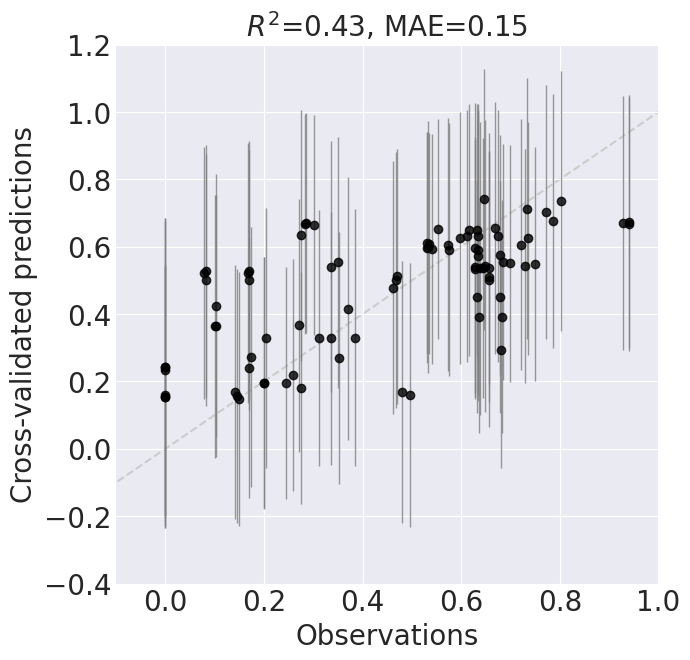

In [29]:
plot.predictions_vs_observations(art_C2, cv=True, error_bars=True,
                                 x_limits=[[-0.1, 1.]], y_limits=[[-0.4, 1.2]])

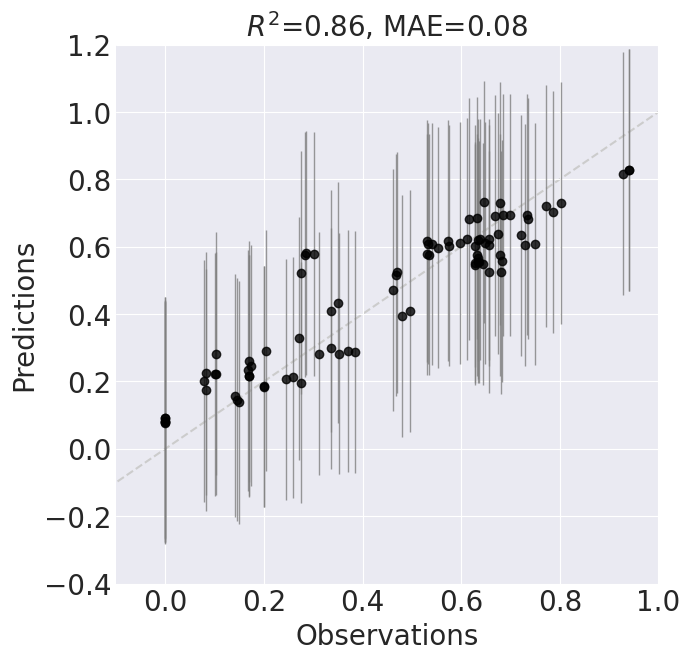

In [30]:
plot.predictions_vs_observations(art_C2, cv=False, error_bars=True,
                                 x_limits=[[-0.1, 1.]], y_limits=[[-0.4, 1.2]])

In [31]:
%%time
draws_2 = art_C2.generate_recommendation_candidates()

Starting parallel tempering using 2 chains…
Done with parallel tempering in 113.12 s
CPU times: user 39.7 ms, sys: 5.07 ms, total: 44.7 ms
Wall time: 1min 53s


Choosing recommendations (19,800 candidates)…


Done choosing recommendations in 0.09 s


,"Dodecanoyl-[acyl-carrier-protein] hydrolase, chloroplastic",LCFA_ECOLI,A1U3L3,dodecan-1-ol
0,113714.928486,197330.340783,618665.409443,0.830894
1,124021.973723,169981.020956,401727.295952,0.802054
2,137493.774714,216246.775375,626208.589182,0.789033
3,126164.999385,217675.036771,423524.397103,0.783688
4,123951.738734,183079.111088,320877.518208,0.771529
5,103019.201854,237411.777272,531574.311609,0.748573
6,131551.825942,260577.483319,645108.264400,0.734059
7,107766.681580,138963.187030,321115.768336,0.728723
8,89314.634523,173379.607798,728018.543267,0.721697
9,122155.969916,142715.242334,253238.269563,0.719300


Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.70 s


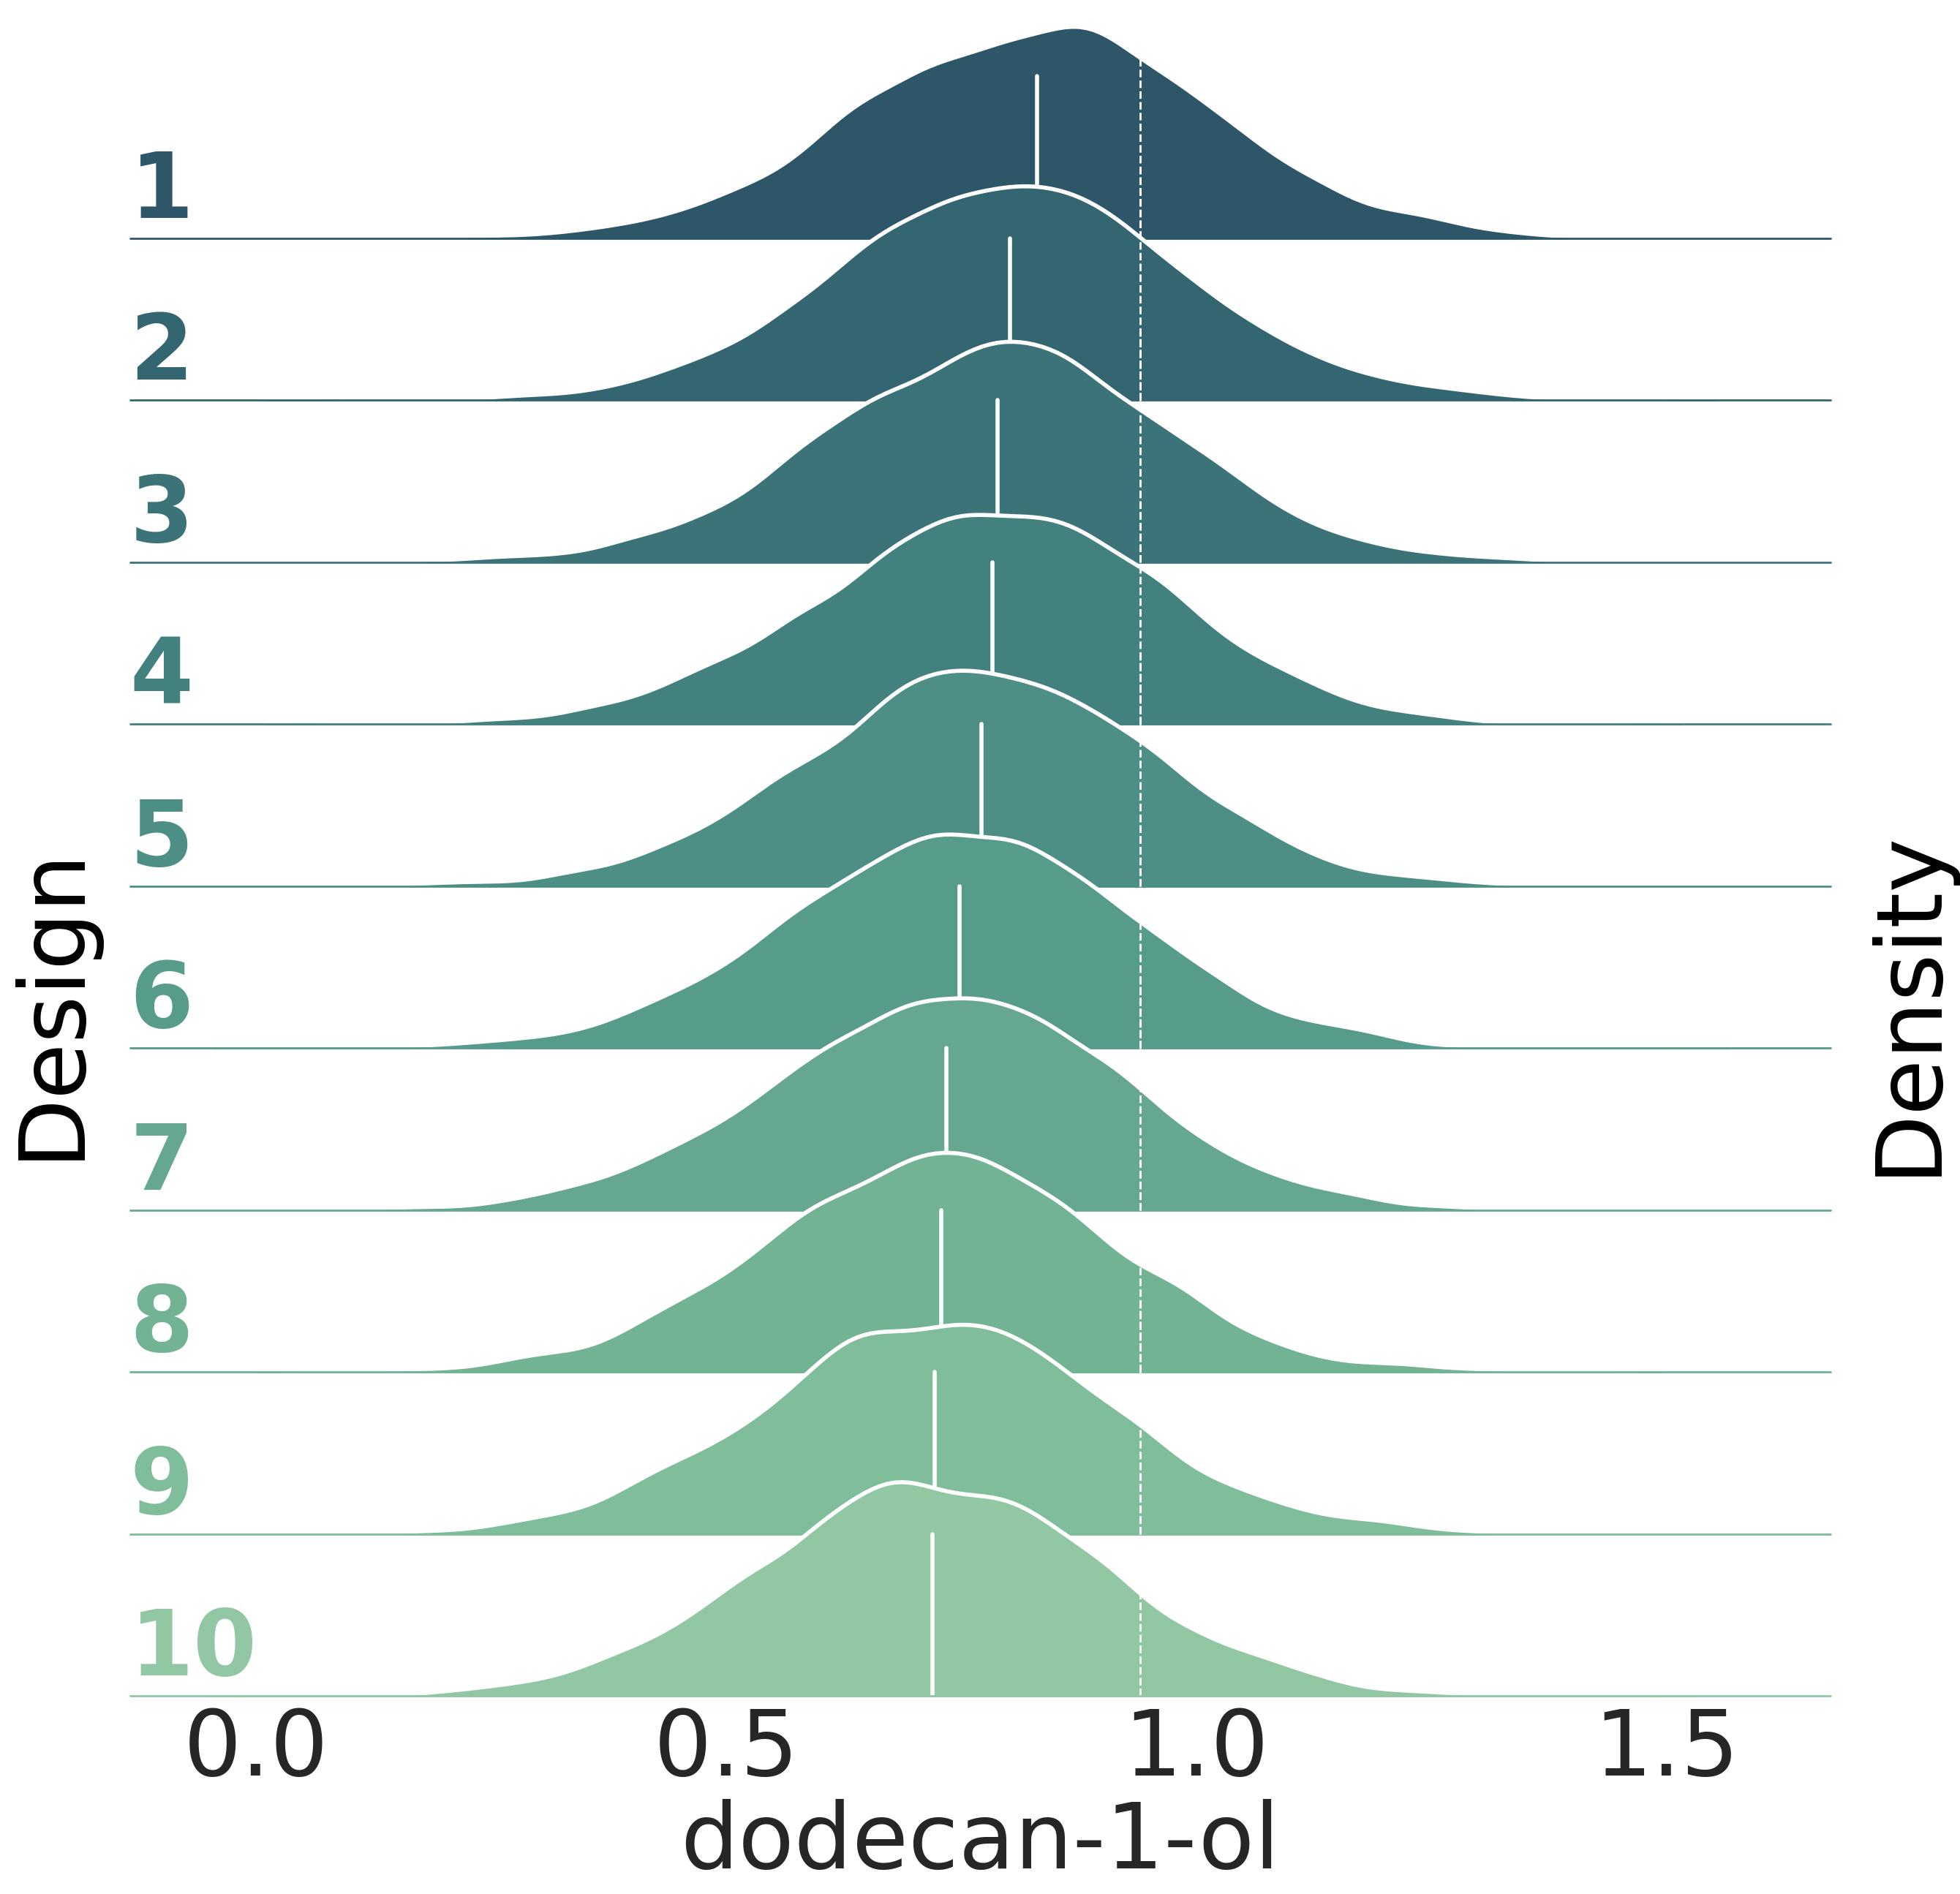

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.86 s
Done computing success probabilities in 0.86 s


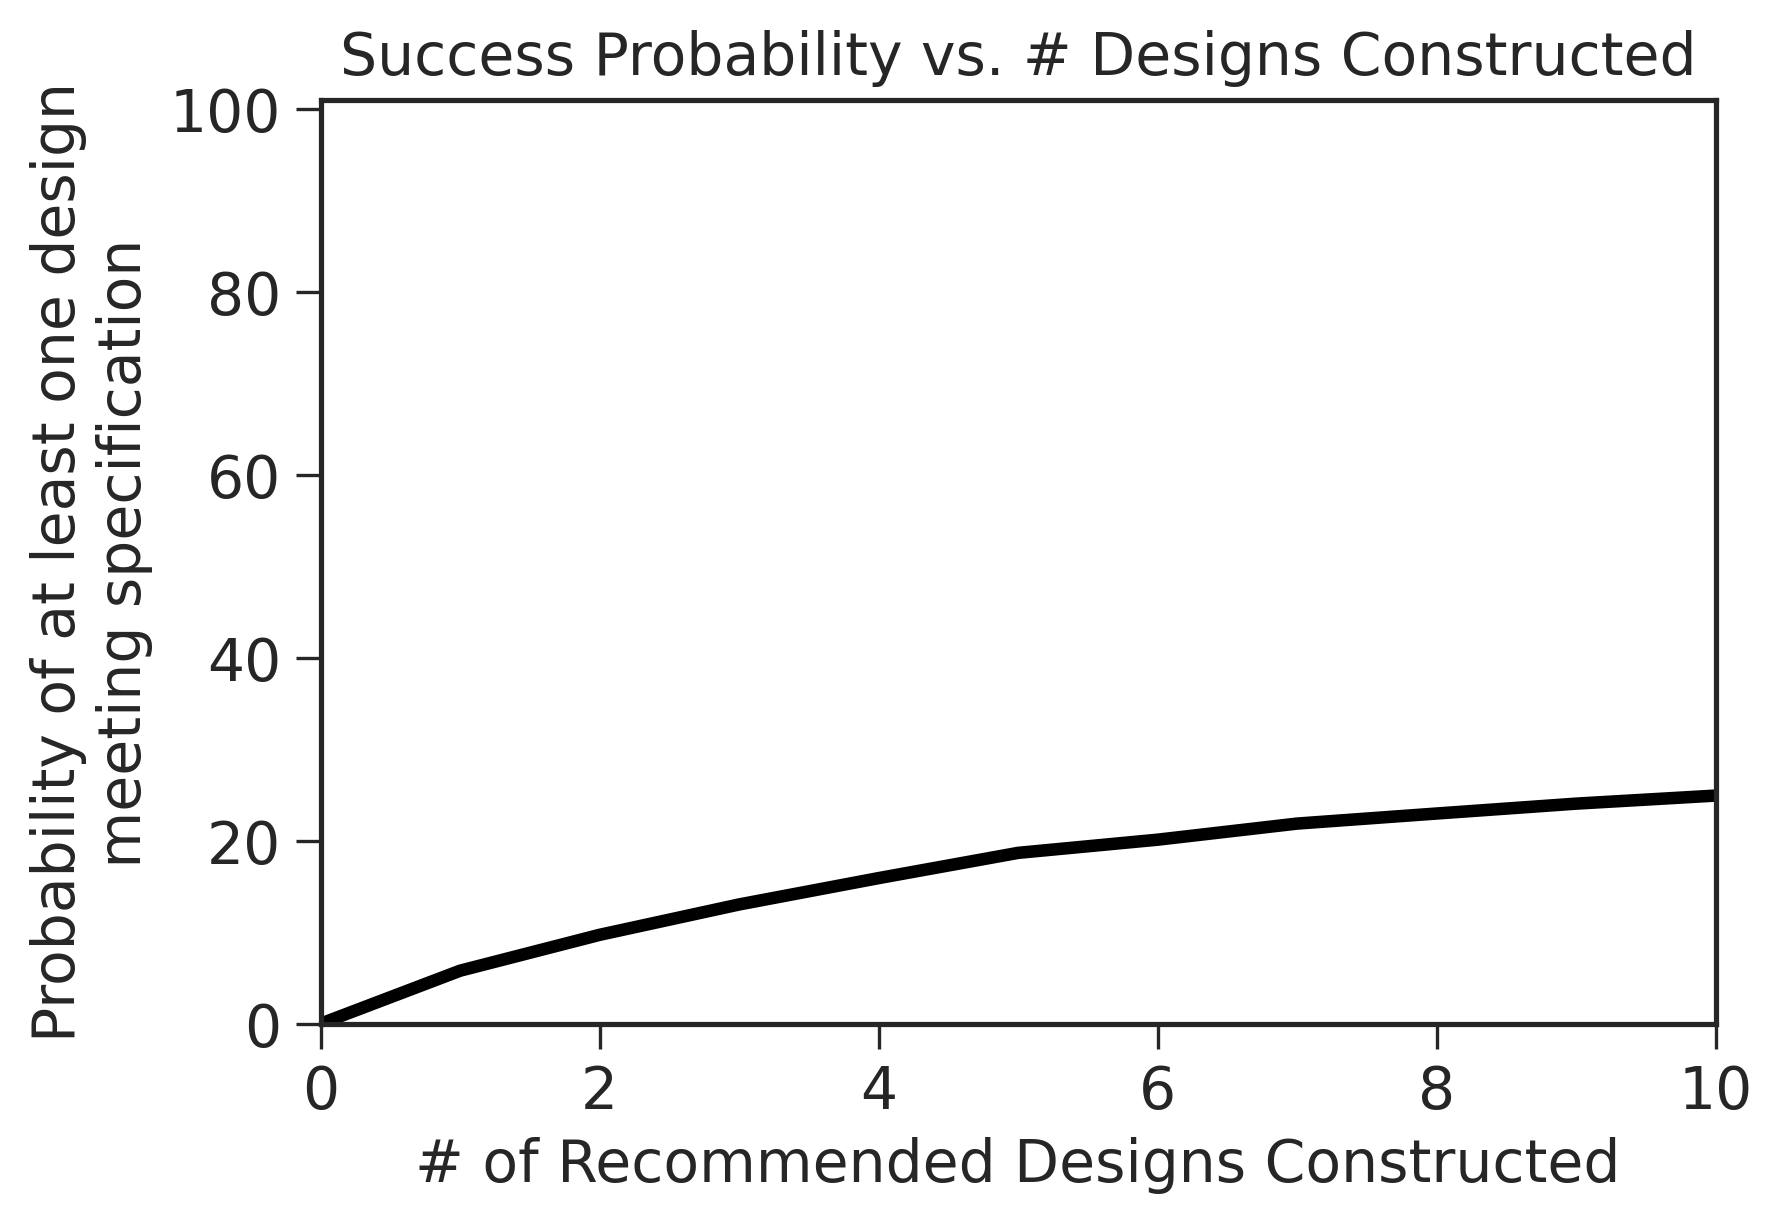

In [32]:
art_C2.select_recommendations(draws_2)

Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.74 s


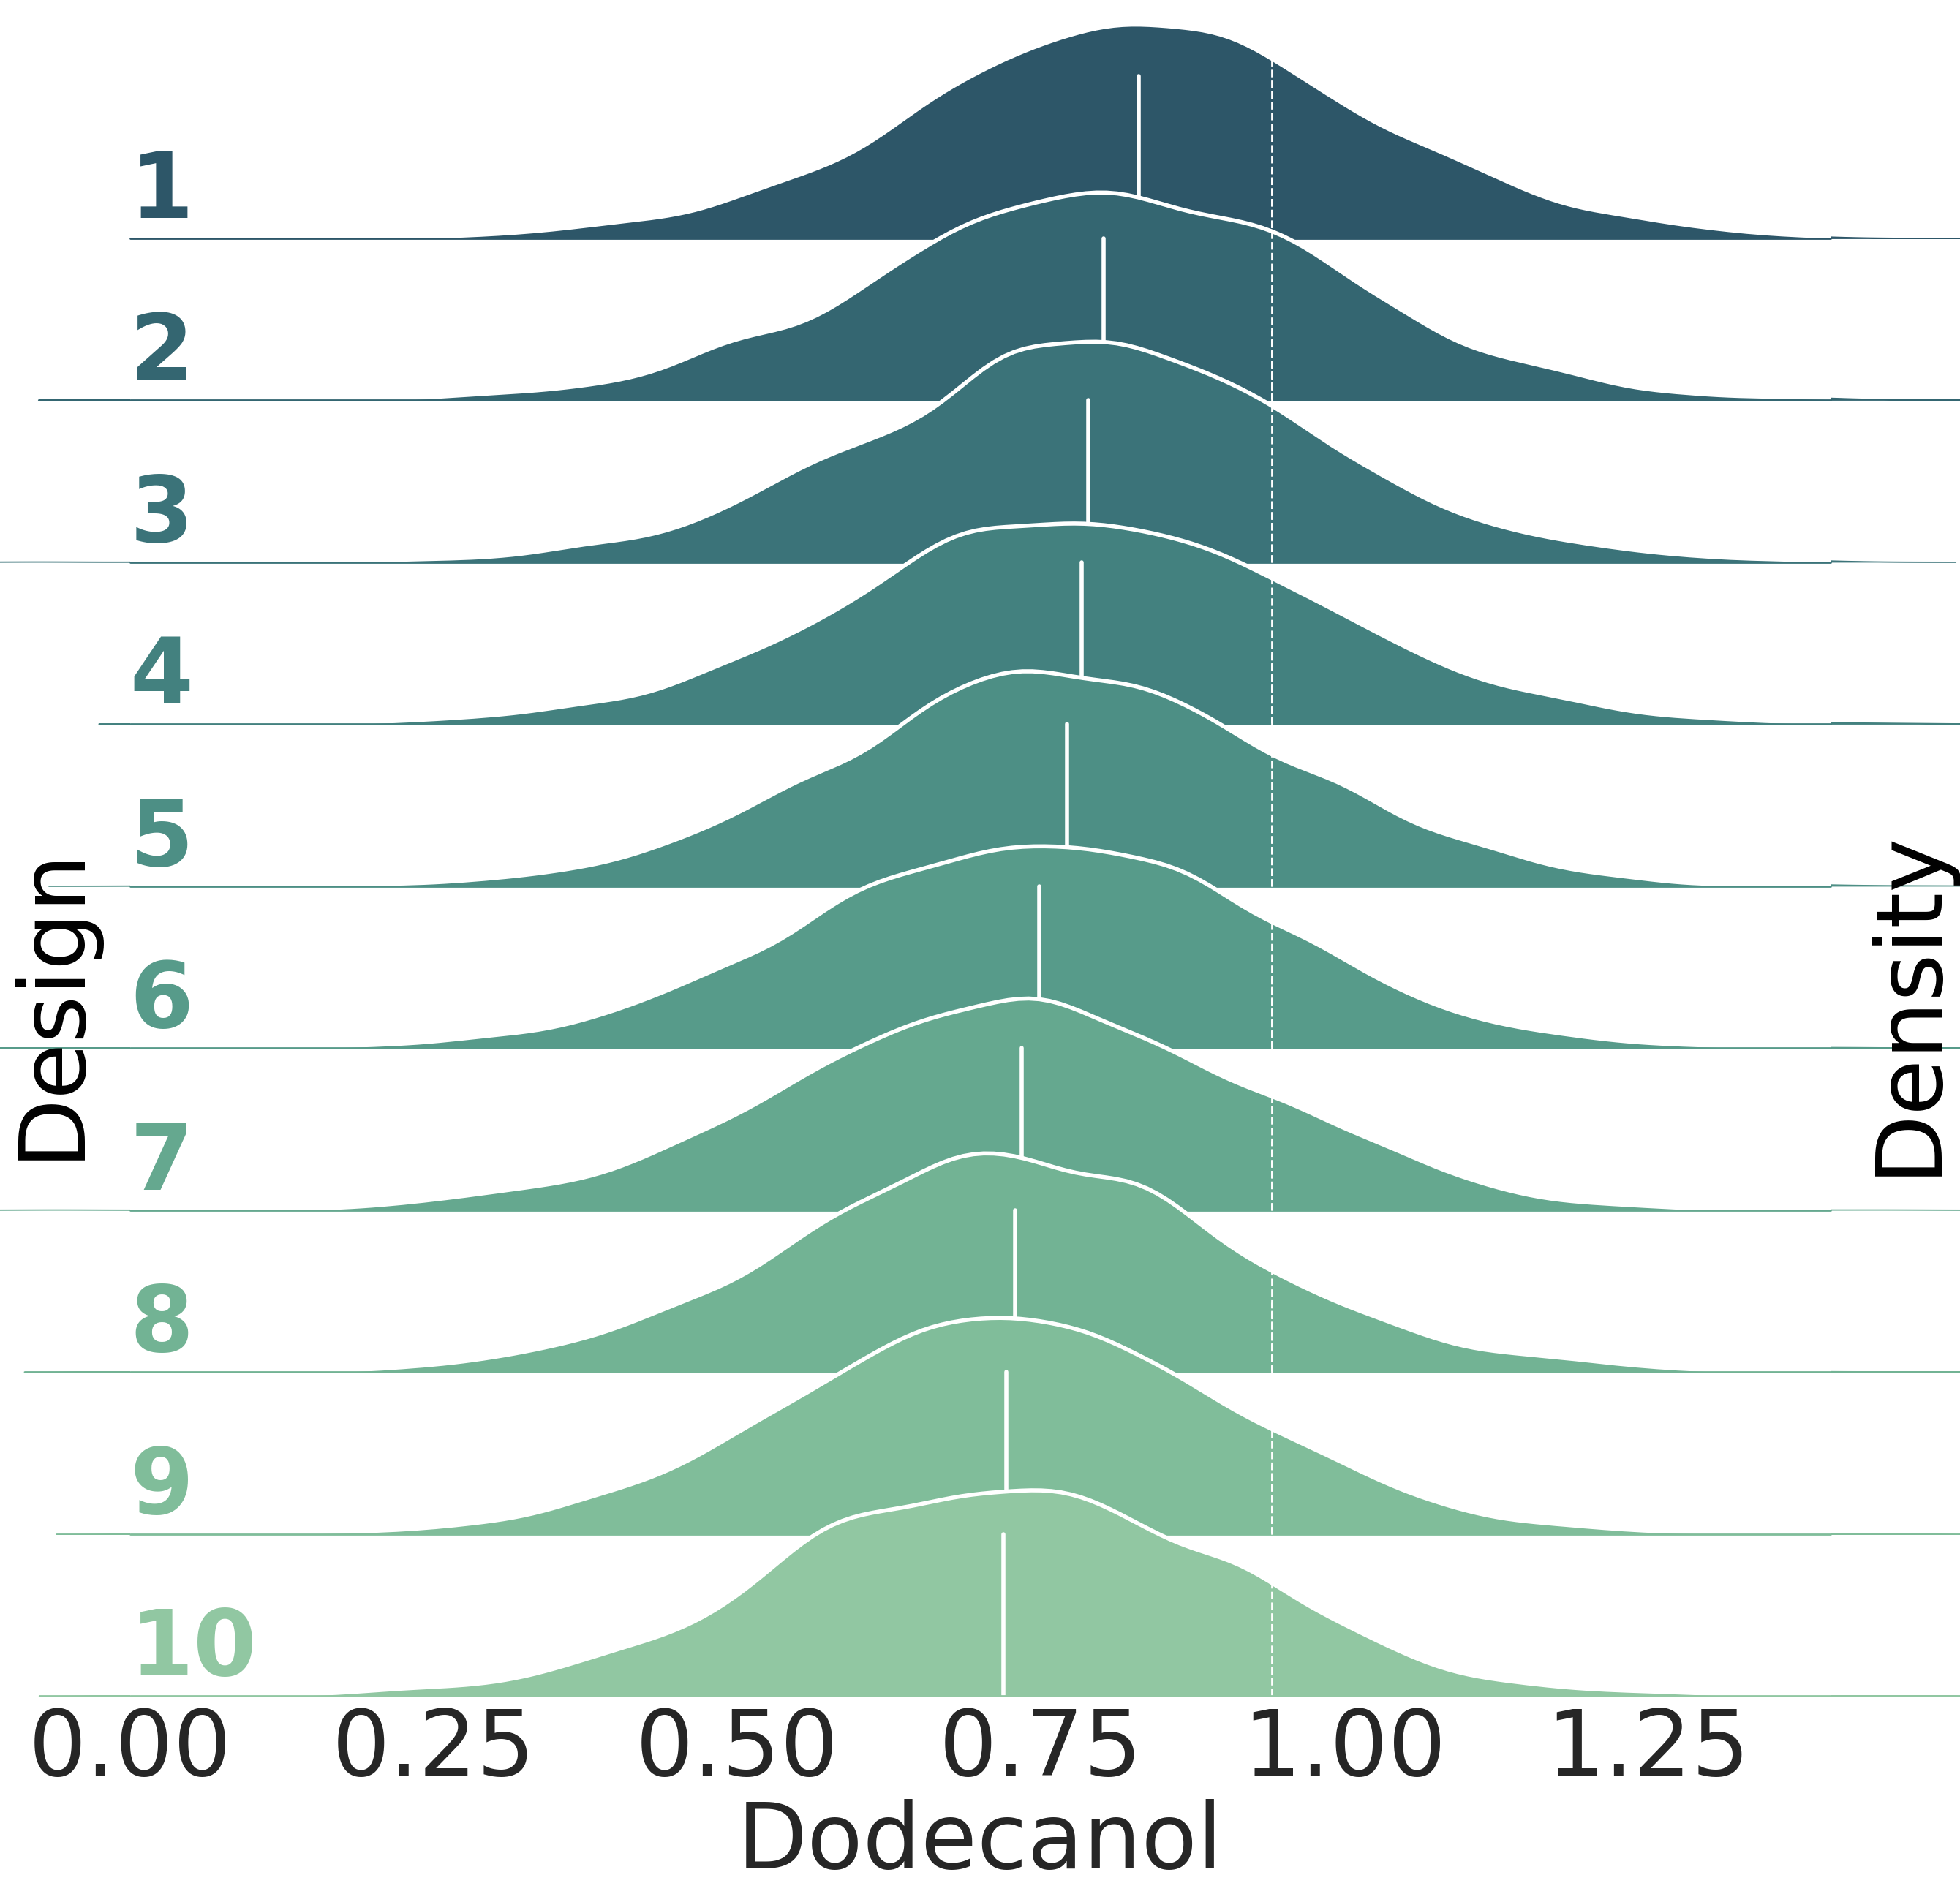

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.71 s
Done computing success probabilities in 0.71 s


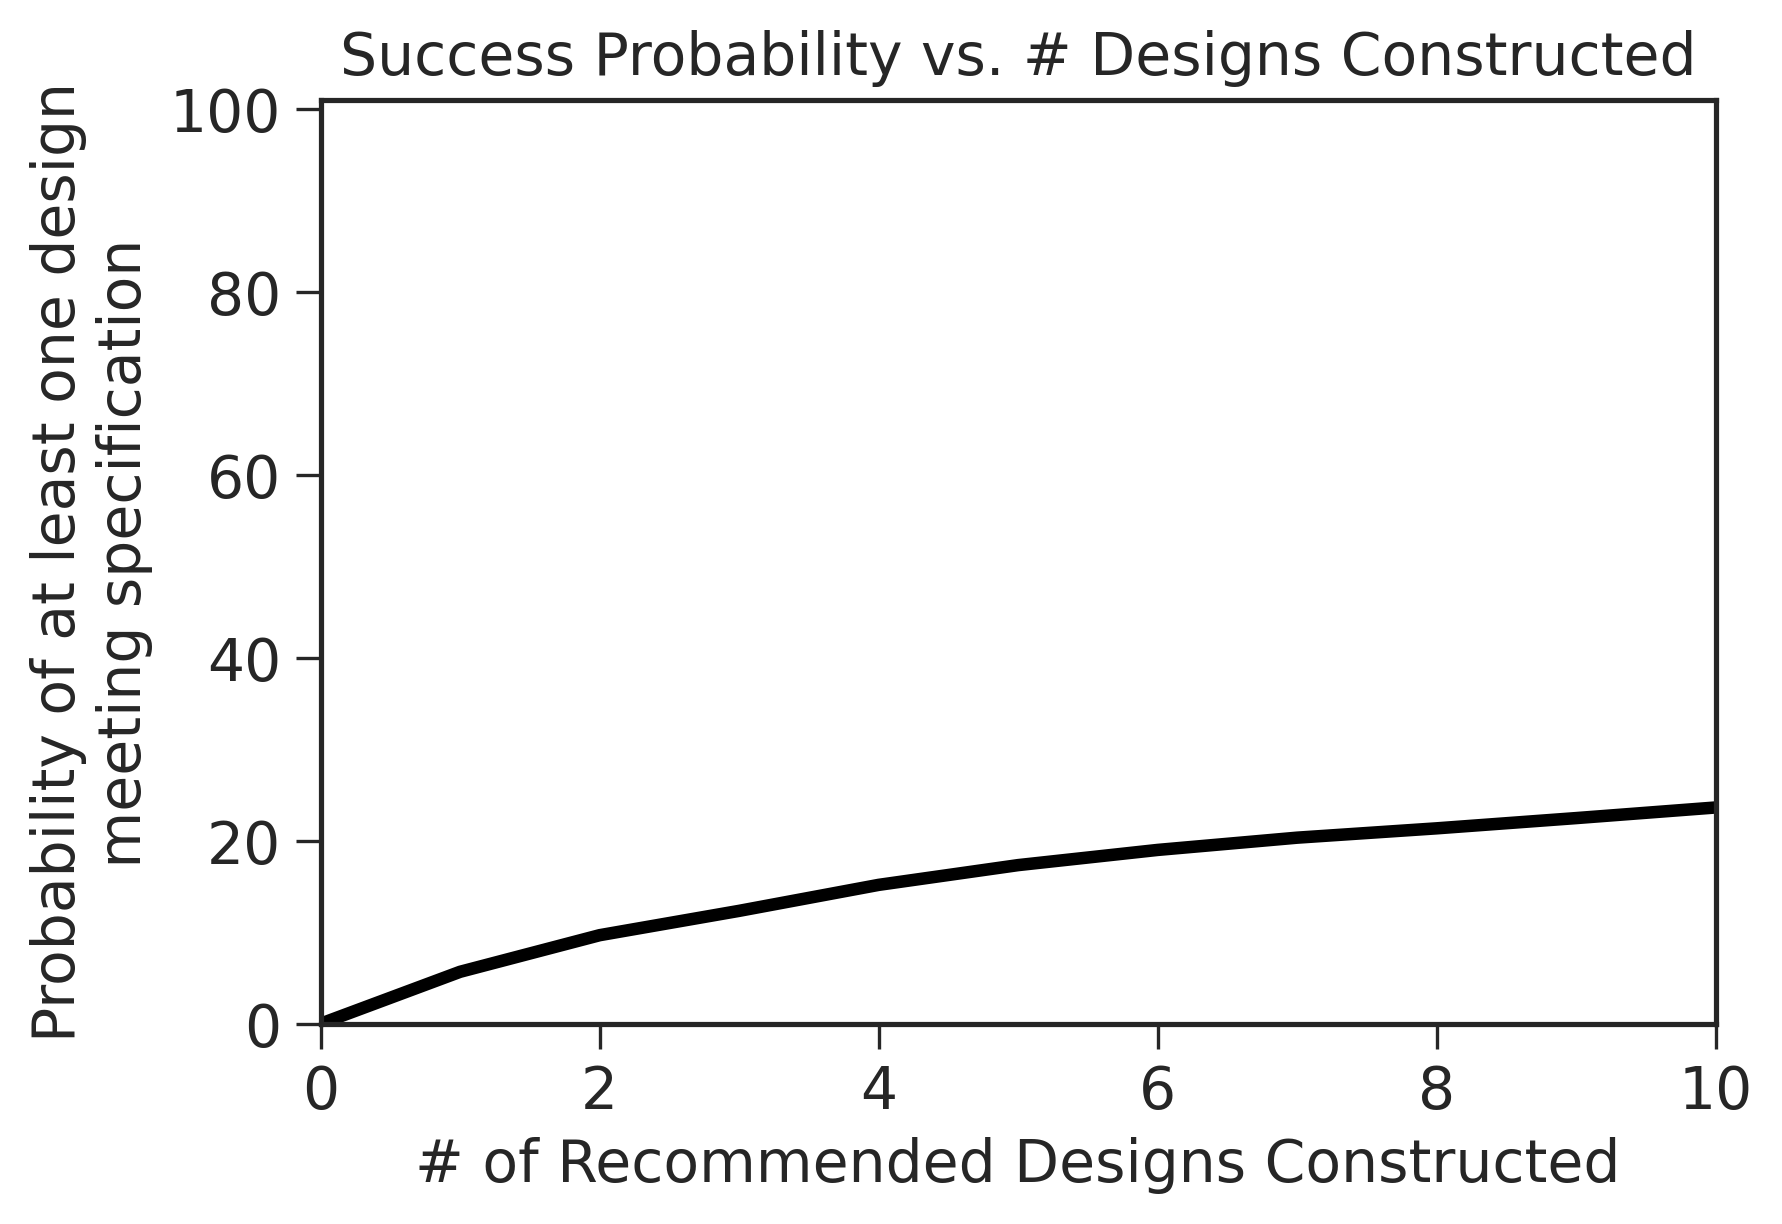

In [33]:
plot.recomm_distribution(art_C2, ['Dodecanol'],[0,1.4])
cum_success_prob = art_C2.compute_success_prob(current_best=art_C2.find_current_best())
plot.success_prob(art_C2, cum_success_prob)

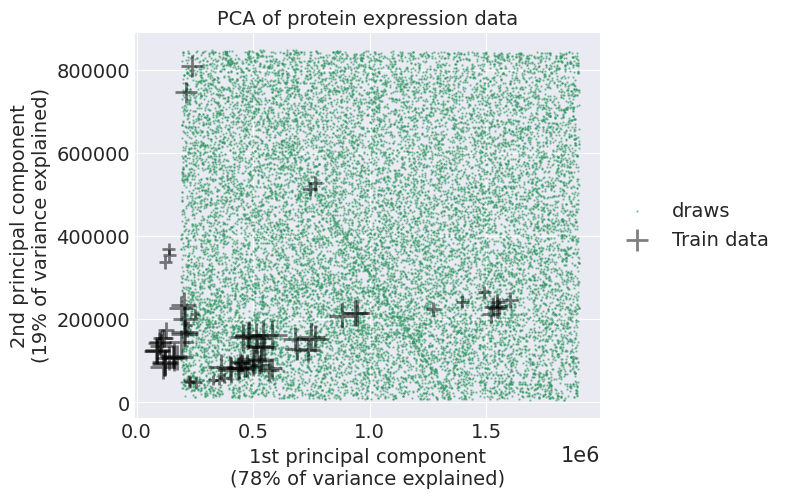

In [34]:
plot.draws_pc(art_C2, draws_2, plot_scale_factor=500, plot_draws=True, plot_kde=False)

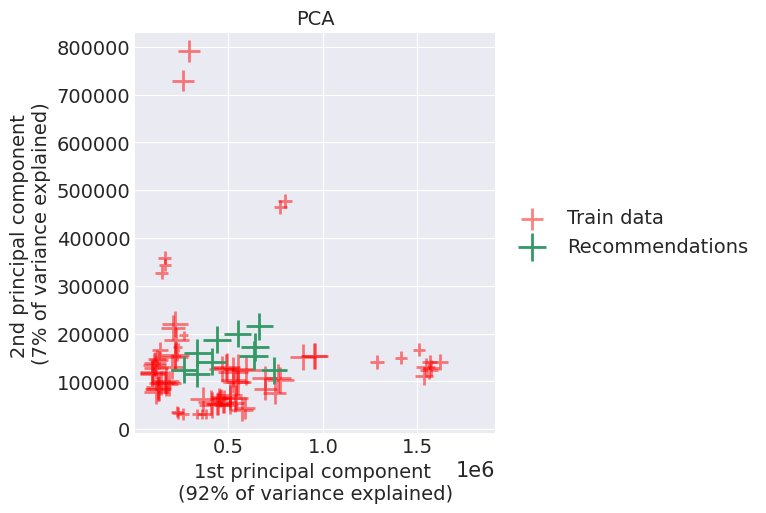

In [35]:
plot.recommendations_pc(art_C2, plot_scale_factor=500)

In [36]:
art_C2.save()